In [91]:
import os
os.chdir(os.path.expanduser("~/phd/phd_nbeats_with_feature_vector"))

import neurokit2 as nk
import numpy as np
import sklearn as sk
from challenge import *
import matplotlib.pyplot as plt
import pandas as pd
from functools import reduce
import math
import ecg_plot
import pywt
from scipy.signal import find_peaks
import functools
import operator
from sklearn import tree




In [2]:
def clean_labels(header):
    logger.debug(f"Clean label for header file: {header}")
    classes_from_header = get_labels(header)
    
    logger.debug(f"Classes found in header: {classes_from_header}")
    if '733534002' in classes_from_header:
        classes_from_header[classes_from_header.index('733534002')] = '164909002'
        classes_from_header = list(set(classes_from_header))
    if '713427006' in classes_from_header:
        classes_from_header[classes_from_header.index('713427006')] = '59118001'
        classes_from_header = list(set(classes_from_header))
    if '63593006' in classes_from_header:
        classes_from_header[classes_from_header.index('63593006')] = '284470004'
        classes_from_header = list(set(classes_from_header))
    if '427172004' in classes_from_header:
        classes_from_header[classes_from_header.index('427172004')] = '17338001'
        classes_from_header = list(set(classes_from_header))

    return classes_from_header


In [3]:
# Constants
data_directory="../data/physionet.org/files/challenge-2021/1.0.3/training/georgia/g1"
leads = ('I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6')

xls = pd.ExcelFile('label_mappings.xlsx')
df = pd.read_excel(xls, 'G12EC')

df_labels_to_class_list=df[['SNOMED code','Diagnosis in the dataset']].set_index('SNOMED code').apply(lambda row: {row.name: row.values.tolist()[0]}, axis=1).tolist()
labels_to_class= reduce(lambda a, b: a|b, df_labels_to_class_list)

# Healthy heart visualisation


Finished loading: 999 files
['426783006']
['sinus rhythm']


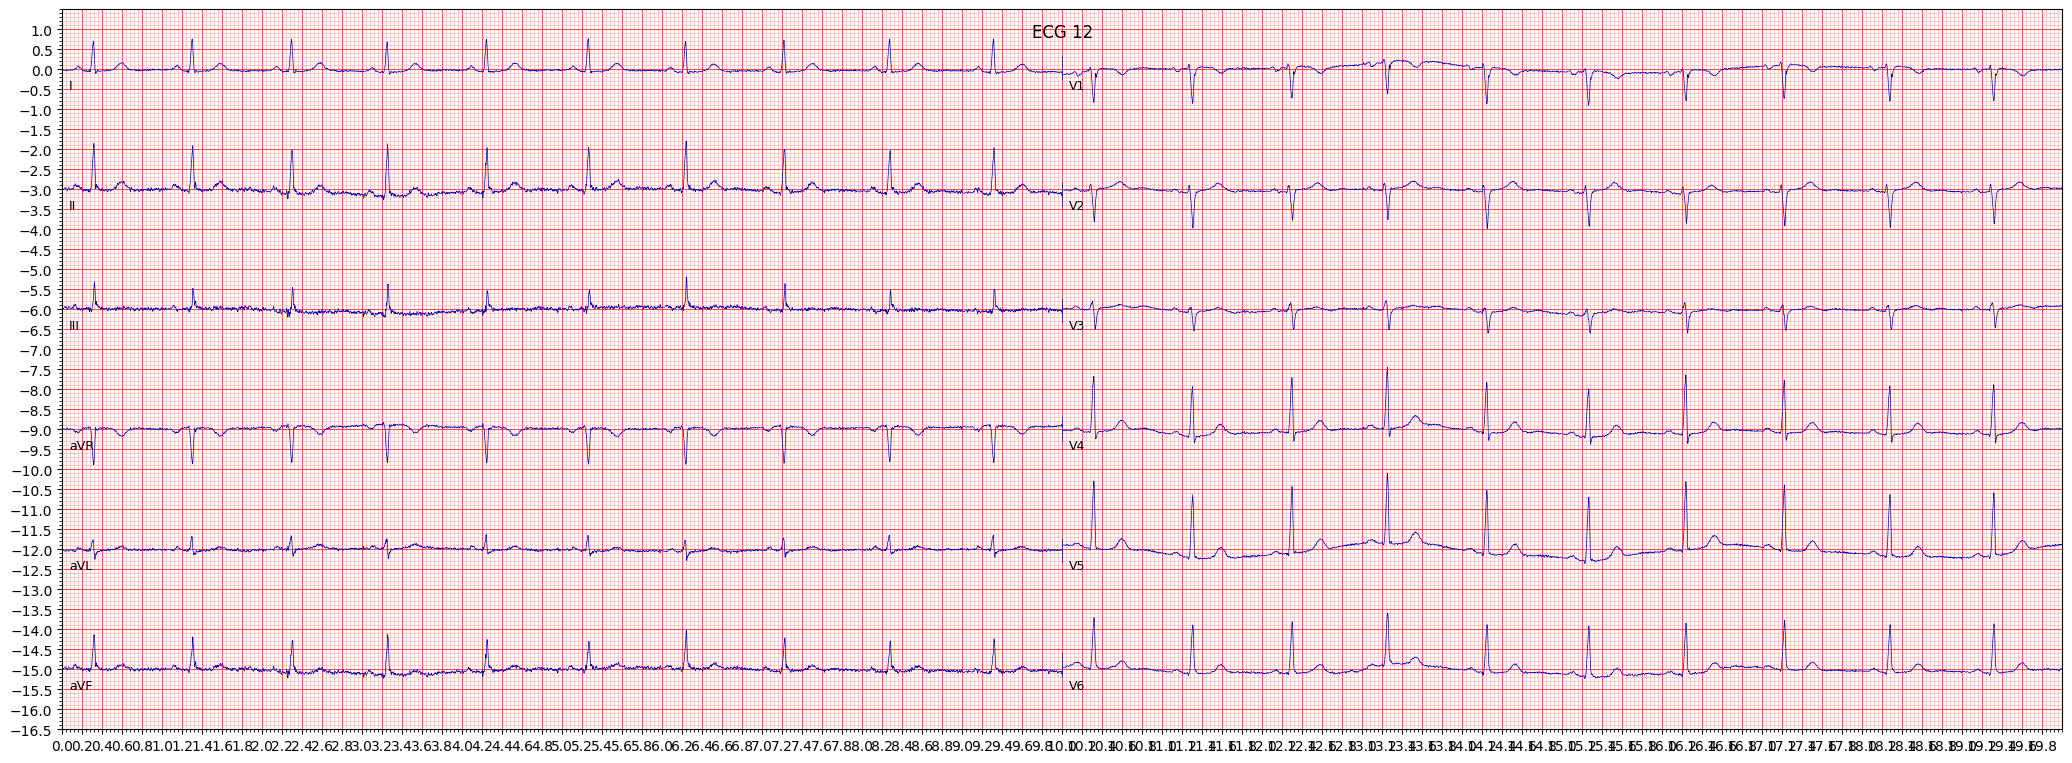

In [4]:

header_files, recording_files = find_challenge_files(data_directory)
num_recordings = len(header_files)
    
print(f"Finished loading: {num_recordings} files")
recording_index = 15

header = load_header(header_files[recording_index])
current_labels= clean_labels(header)
print(current_labels)
current_abbreviations=[labels_to_class[int(label)] for label in current_labels]
print(current_abbreviations)

recording_good = np.array(load_recording(recording_files[recording_index]), dtype=np.float32)
recording_full = get_leads_values(header, recording_good, leads)

ecg_plot.plot(recording_good / 1000, sample_rate = 500, title = 'ECG 12')
ecg_plot.show()


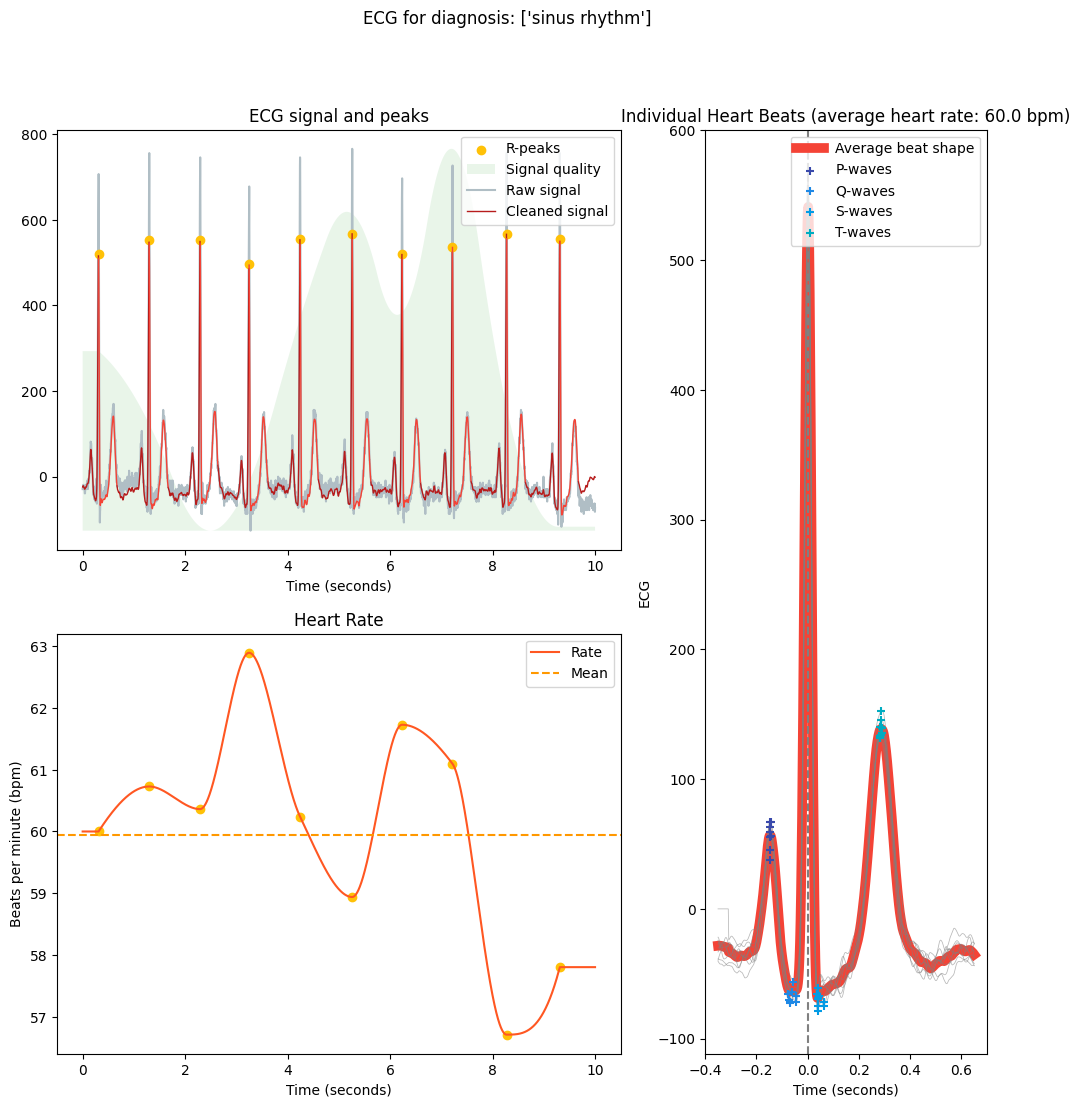

In [5]:
signals_good, info_good = nk.ecg_process(recording_good[0], sampling_rate=500)

# Visualise the processing
nk.ecg_plot(signals_good, info_good)
fig = plt.gcf() 
fig.set_size_inches(12, 12, forward=True)
fig.suptitle(f"ECG for diagnosis: {current_abbreviations}")

bpm=np.mean(nk.ecg_rate(signals_good, sampling_rate=500))


Text(0.5, 0.98, "ECG Lead V1 for diagnosis: ['sinus rhythm']")

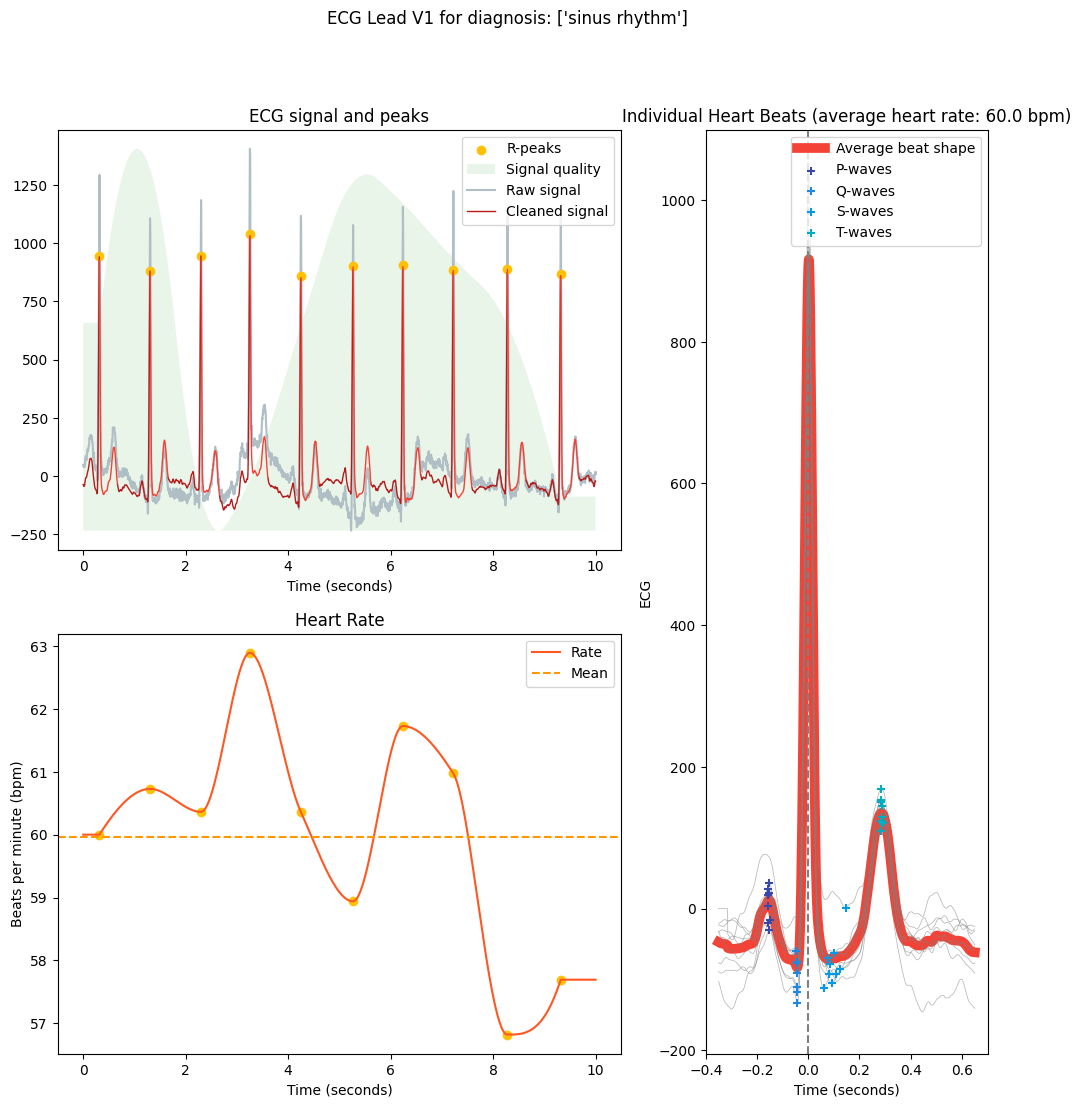

In [6]:
signals_V6, info_V6 = nk.ecg_process(recording_good[11], sampling_rate=500)
# Visualise the processing

#This plot is good but R peaks are totally wrong (they should be at the lowest peak).
nk.ecg_plot(signals_V6, info_V6)
fig = plt.gcf() 
fig.set_size_inches(12, 12, forward=True)
fig.suptitle(f"ECG Lead V1 for diagnosis: {current_abbreviations}")


Is inverted: True


Text(0.5, 0.98, "ECG Lead V1 for diagnosis: ['sinus rhythm']")

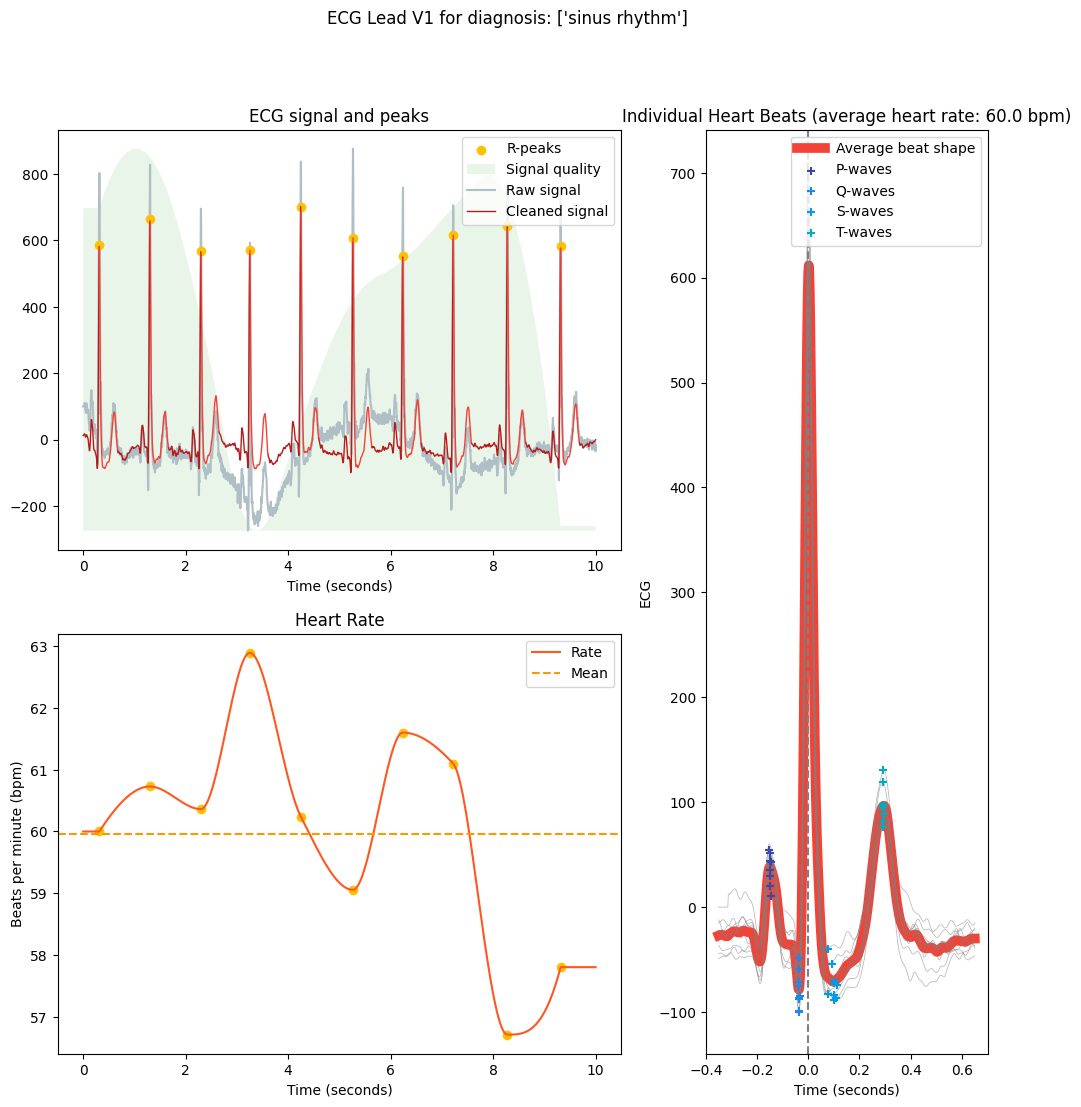

In [7]:
ecg, inverted = nk.ecg_invert(recording_good[6], sampling_rate=500)
print(f"Is inverted: {inverted}")
signals_V6, info_V6 = nk.ecg_process(ecg, sampling_rate=500)

# Visualise the processing

#This plot is good but R peaks are totally wrong (they should be at the lowest peak).
nk.ecg_plot(signals_V6, info_V6)
fig = plt.gcf() 
fig.set_size_inches(12, 12, forward=True)
fig.suptitle(f"ECG Lead V1 for diagnosis: {current_abbreviations}")


# Leading rythm assessment
- Bradycardia -> BPM below 50
- Normocardia -> BPM between 50 and 100
- Tachycardia -> BPM abowe 100

In [8]:
def leading_rythm(bpm):
    if(bpm < 50):
       return -1
    elif (50< bpm < 100):
        return 0
    else:
        return 1

leading_rythm(bpm)

0

# Rhythm origins and heart electrical axis assesment

In [97]:
def get_wavelet_orientation(onset, peak, offset):
    if peak > (onset+offset)/2 :
        return 1
    else:
        return -1

#R->L (correct) return 1, L->R (incorrect) return -1 LEAD I
def get_right_left_activation_leadI(p_complexes):
    return np.mean([get_wavelet_orientation(*px) for px in p_complexes])

#Correct sinus return 1 (pwave positive), Extra sinus orign return -1 (pwave negative) on lead II or lead III or aVF
def get_vertical_orientation(p_complexes):
    return np.mean([get_wavelet_orientation(*px) for px in p_complexes])

def get_p_complex(signals, info):
    num_peaks = len(info['ECG_P_Peaks'])
    result=[]
    for i in range(num_peaks):
        p_on = info['ECG_P_Onsets'][i]
        p = info['ECG_P_Peaks'][i]
        p_off = info['ECG_P_Offsets'][i]

        if np.isnan([p_on, p, p_off]).any():
            continue

        p_complex = [signals.iloc[p_on]['ECG_Raw'], signals.iloc[p]['ECG_Raw'], signals.iloc[p_off]['ECG_Raw']]
        
        if np.isnan(p_complex).any():
            continue
        else:
            result.append(p_complex)
    return result
    
#          | R   |  L
#---------------------
# top-down | 1 1 | 1 -1
#---------------------
# down-top | -1 1 | -1 -1
def get_rhythm_origin(signalsI, infoI, signalsII, infoII):
    I_pcomplexes = get_p_complex(signalsI, infoI)
    II_pcomplexes = get_p_complex(signalsII, infoII)

    return get_vertical_orientation(II_pcomplexes), get_right_left_activation_leadI(I_pcomplexes)
    



#https://www.cmj.hr/1999/40/1/9933900.htm
def get_heart_axis(leadI_QRS, leadaVF_QRS):
    results=[]
    lenI = len(leadI_QRS)
    lenaVF = len(leadaVF_QRS)
    target_len = 0
    if lenI >= lenaVF:
        target_len = lenaVF
    else:
        target_len = lenI
        
    for i in range(target_len):
        aVF_QRS=leadaVF_QRS[i]
        I_QRS=leadI_QRS[i]
        altitudeAVF=sum(aVF_QRS)
        altitudeI=sum(I_QRS)
        results.append(math.degrees(math.atan2((2*altitudeAVF),(math.sqrt(3)*altitudeI))))
    return results

def get_QRS_from_lead(signals, info):
    num_peaks = len(info['ECG_R_Peaks'])
    result = []
    for i in range(num_peaks):
        Q = info['ECG_Q_Peaks'][i]
        R = info['ECG_R_Peaks'][i]
        S = info['ECG_S_Peaks'][i]

        QRS_ts= [Q, R, S]
        if np.isnan(QRS_ts).any():
            continue

        QRS = [signals.iloc[Q]['ECG_Raw'], signals.iloc[R]['ECG_Raw'], signals.iloc[S]['ECG_Raw']]
        if np.isnan(QRS).any():
            continue
        else:
            result.append(QRS)
    
    return result
        


In [10]:
signals_I, info_I = nk.ecg_process(recording_good[0], sampling_rate=500)
signals_II, info_II = nk.ecg_process(recording_good[1], sampling_rate=500)
signals_aVF, info_aVF = nk.ecg_process(recording_good[5], sampling_rate=500)

QRS_I = get_QRS_from_lead(signals_I, info_I)
QRS_aVF = get_QRS_from_lead(signals_aVF, info_aVF)



print(QRS_I)
print(QRS_aVF)
print(get_heart_axis(QRS_I, QRS_aVF))
print(get_rhythm_origin(signals_I, info_I, signals_II, info_II))

[[-58.0, 678.0, -48.0], [-73.0, 746.0, -63.0], [-63.0, 736.0, -73.0], [-78.0, 629.0, -78.0], [-63.0, 746.0, -58.0], [-53.0, 766.0, -63.0], [-87.0, 678.0, -73.0], [-87.0, 678.0, -63.0], [-82.0, 736.0, -73.0]]
[[-65.0, 866.0, -41.0], [-29.0, 763.0, -29.0], [-219.0, 695.0, -134.0], [-226.0, 868.0, -158.0], [-187.0, 744.0, -36.0], [-100.0, 695.0, 17.0], [-21.0, 973.0, -26.0], [-70.0, 695.0, -61.0], [-90.0, 707.0, -95.0]]
[56.90376898224057, 53.15479077924754, 33.35208523705128, 49.757326231528296, 43.907045380485656, 47.39220601826183, 64.15210896366779, 50.966686621913425, 46.05279827575479]
(1.0, 1.0)


# Check for missing QRS complexes and retrieve qrs statistics
- QRS Duration
- Missing QRS
- Missing P
- S duration


In [101]:
#Check if there are missing QRS complexes, if so we diagnose atrioventricular block
def has_missing_qrs(signals, info):
    R_peaks = info['ECG_R_Peaks']
    distances = [R_peaks[i] - R_peaks[i-1] for i in range(1, len(R_peaks))]
    quantile90=np.quantile(distances,0.9)
    quantile10=np.quantile(distances,0.1)
    mean_without_outliers = np.mean([d for d in distances if (d>quantile10 and d<quantile90)])
    is_missing_qrs = distances > (mean_without_outliers * 1.5)
    return any(is_missing_qrs)


def has_missing_p(signals, info):
    num_of_p = np.count_nonzero(~np.isnan(info['ECG_P_Peaks']))
    num_of_beats = len(info['ECG_R_Peaks'])
    return num_of_p < (num_of_beats - 1)
    

def get_QRS_duration(signals, info, freq=500):
    num_peaks = min([len(info['ECG_R_Peaks']), len(info['ECG_Q_Peaks']), len(info['ECG_S_Peaks'])])
    result = []
    for i in range(num_peaks):
        Q = info['ECG_Q_Peaks'][i]
        R = info['ECG_R_Peaks'][i]
        S = info['ECG_S_Peaks'][i]
        if any(np.isnan([Q,R,S])):
            continue
        else:
            result.append((S-Q)/freq)

    return result

def get_S_duration(signals, info, freq=500):
    num_peaks = len(info['ECG_R_Peaks'])
    result = []
    for i in range(num_peaks):
        s = info['ECG_S_Peaks'][i]
        r = info['ECG_R_Peaks'][i]
        if any(np.isnan([r,s])):
            continue
        else:
            result.append((s-r)/freq)
    return result


def get_R_duration(signals, info, freq=500):
    num_peaks = len(info['ECG_R_Peaks'])
    result = []
    for i in range(num_peaks):
        R = info['ECG_R_Peaks'][i]
        R_on = info['ECG_R_Onsets'][i]
        R_off = info['ECG_R_Offsets'][i]
        S = info['ECG_S_Peaks'][i]
        if any(np.isnan([R,R_on, R_off, S])):
            continue
        else:
            if S < R_off:
                result.append((S - R_on)/freq)
            else:
                result.append((R_off - R_on)/freq)

    return result

    


has_missing_qrs(signals_I, info_I)
has_missing_p(signals_I, info_I)
get_QRS_duration(signals_I, info_I)
get_S_duration(signals_I, info_I)

[0.044,
 0.042,
 0.04,
 0.038,
 0.04,
 0.038,
 0.044,
 0.04,
 0.038,
 0.042,
 0.04,
 0.044,
 0.038,
 0.04]

# RBBB signal analysis
- S longer than 40ms or longer in duration than R in leads I or V6
- RsR', rSR' rsR' complex in V1 or V2
- QRS > 120ms
- negative return delayed of more than 50ms in V1
- ST-T leaning oposite to main QRS
  

Finished loading: 1000 files
A2000 12 500 8604
A2000.mat 16x1+24 1000.0(0)/mV 16 0 23 -2 0 I
A2000.mat 16x1+24 1000.0(0)/mV 16 0 28 -14 0 II
A2000.mat 16x1+24 1000.0(0)/mV 16 0 6 -33 0 III
A2000.mat 16x1+24 1000.0(0)/mV 16 0 -25 -22 0 aVR
A2000.mat 16x1+24 1000.0(0)/mV 16 0 9 6 0 aVL
A2000.mat 16x1+24 1000.0(0)/mV 16 0 18 -36 0 aVF
A2000.mat 16x1+24 1000.0(0)/mV 16 0 15 -18 0 V1
A2000.mat 16x1+24 1000.0(0)/mV 16 0 27 5 0 V2
A2000.mat 16x1+24 1000.0(0)/mV 16 0 23 10 0 V3
A2000.mat 16x1+24 1000.0(0)/mV 16 0 17 -15 0 V4
A2000.mat 16x1+24 1000.0(0)/mV 16 0 11 -24 0 V5
A2000.mat 16x1+24 1000.0(0)/mV 16 0 23 -43 0 V6
# Age: 61
# Sex: Female
# Dx: 59118001
# Rx: Unknown
# Hx: Unknown
# Sx: Unknown

['59118001']
['right bundle branch block']


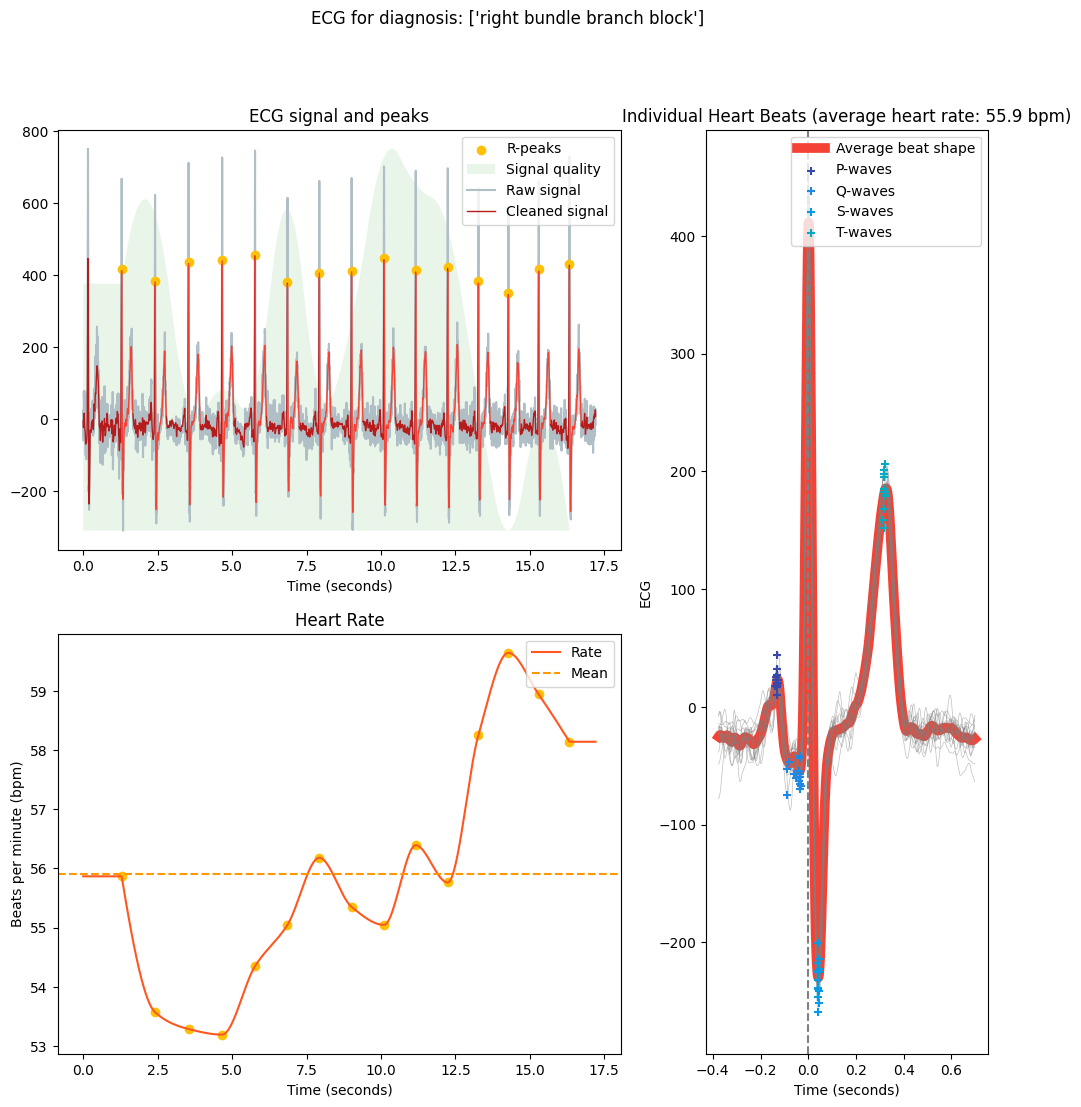

False
False
[0.078, 0.104, 0.076, 0.128, 0.08, 0.12, 0.078, 0.072, 0.074, 0.08, 0.094, 0.086, 0.128, 0.078]


In [13]:
#RBBB
data_directory="../data/physionet.org/files/challenge-2021/1.0.3/training/cpsc_2018/g3"

header_files, recording_files = find_challenge_files(data_directory)
num_recordings = len(header_files)
index_RBBB = header_files.index('../data/physionet.org/files/challenge-2021/1.0.3/training/cpsc_2018/g3/A2000.hea')
    
print(f"Finished loading: {num_recordings} files")

header = load_header(header_files[index_RBBB])
print(header)
current_labels= clean_labels(header)
print(current_labels)
current_abbreviations=[labels_to_class[int(label)] for label in current_labels]
print(current_abbreviations)

recording = np.array(load_recording(recording_files[index_RBBB]), dtype=np.float32)
recording_full = get_leads_values(header, recording, leads)

signals_I, info_I = nk.ecg_process(recording[0], sampling_rate=500)

# Visualise the processing
plt.close()
nk.ecg_plot(signals_I, info_I)
fig = plt.gcf() 
fig.set_size_inches(12, 12, forward=True)
fig.suptitle(f"ECG for diagnosis: {current_abbreviations}")
plt.show()

bpm=np.mean(nk.ecg_rate(signals_I, sampling_rate=500))

print(has_missing_qrs(signals_I, info_I))
print(has_missing_p(signals_I, info_I))
print(get_QRS_duration(signals_I, info_I))


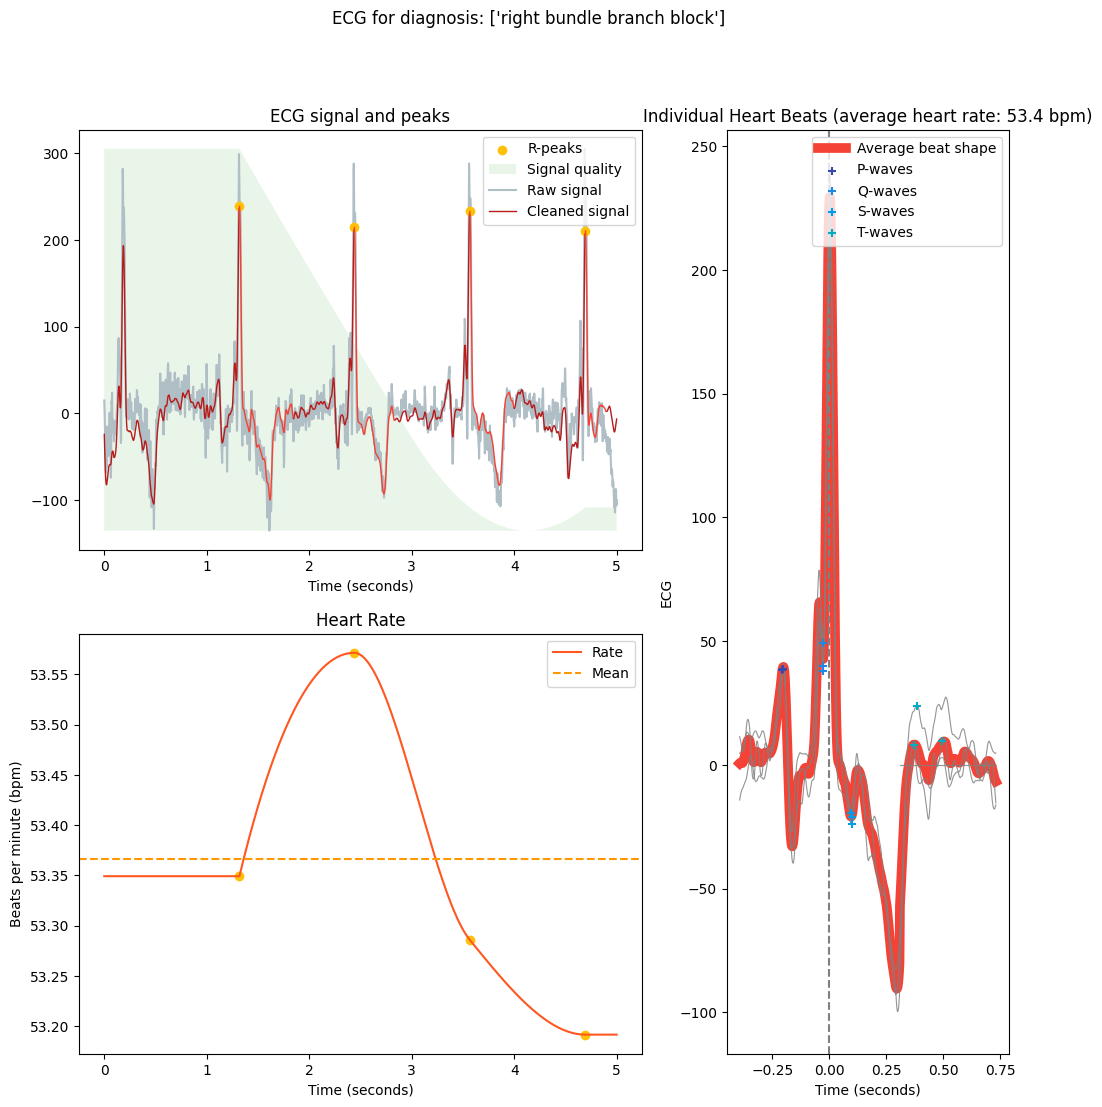

False
False
[0.126, 0.124, 0.12]
[0.096, 0.096, 0.092]


In [14]:
signals_V1, info_V1 = nk.ecg_process(recording[6][:2500], sampling_rate=500)

# Visualise the processing
plt.close()
nk.ecg_plot(signals_V1, info_V1)
fig = plt.gcf() 
fig.set_size_inches(12, 12, forward=True)
fig.suptitle(f"ECG for diagnosis: {current_abbreviations}")
plt.show()

bpm=np.mean(nk.ecg_rate(signals_V1, sampling_rate=500))

print(has_missing_qrs(signals_V1, info_V1))
print(has_missing_p(signals_V1, info_V1))
print(get_QRS_duration(signals_V1, info_V1))
print(get_S_duration(signals_V1, info_V1))

Is inverted: False


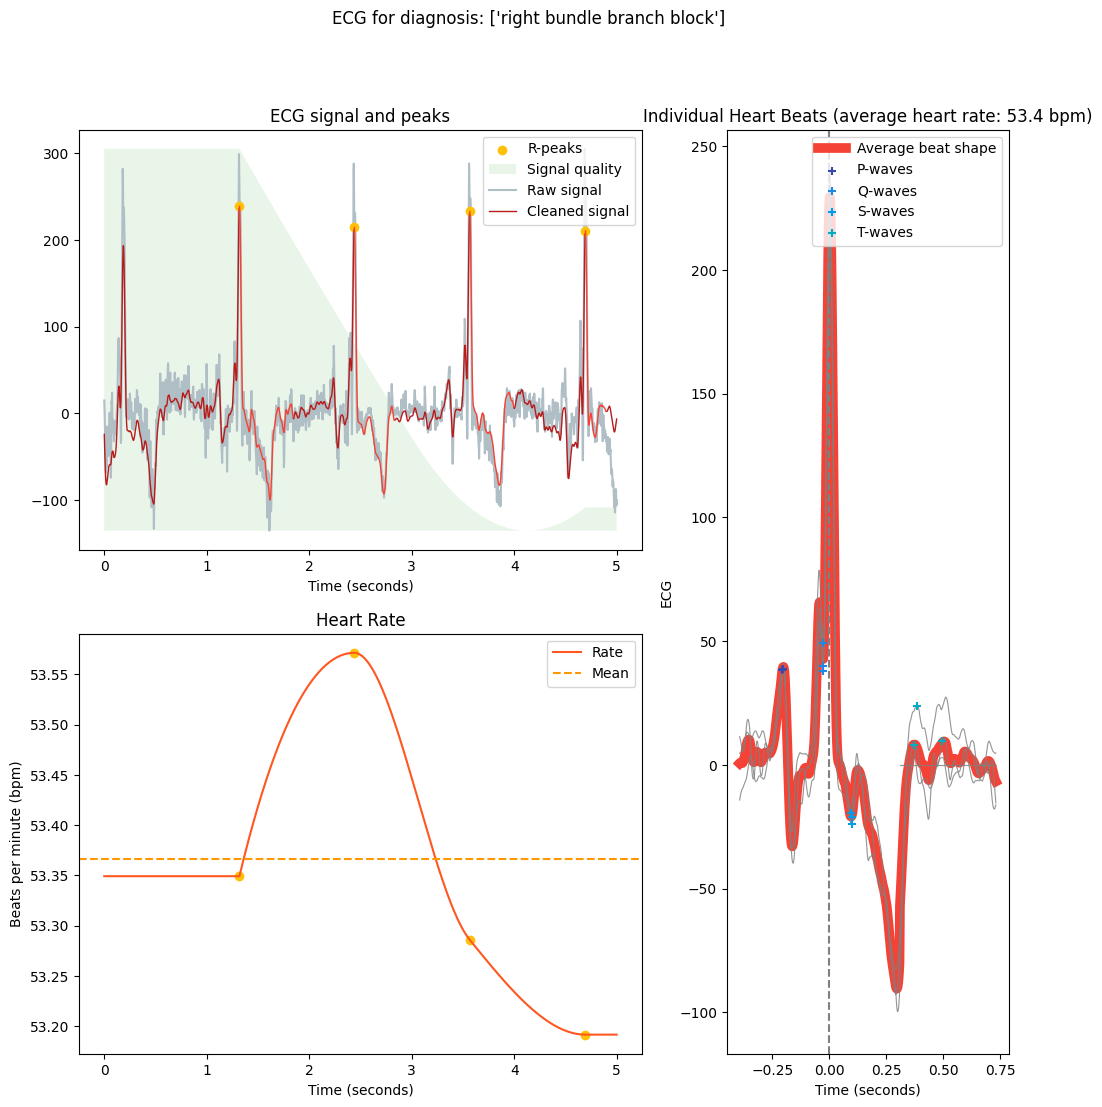

In [15]:
ecg, inverted = nk.ecg_invert(recording[6][:2500], sampling_rate=500)
print(f"Is inverted: {inverted}")

signals_V1, info_V1 = nk.ecg_process(ecg, sampling_rate=500)

# Visualise the processing
plt.close()
nk.ecg_plot(signals_V1, info_V1)
fig = plt.gcf() 
fig.set_size_inches(12, 12, forward=True)
fig.suptitle(f"ECG for diagnosis: {current_abbreviations}")
plt.show()

{'method_peaks': 'neurokit', 'method_fixpeaks': 'None', 'ECG_R_Peaks': array([ 659, 1219, 1782, 2346]), 'ECG_R_Peaks_Uncorrected': array([ 659, 1219, 1782, 2346]), 'ECG_fixpeaks_ectopic': [], 'ECG_fixpeaks_missed': [], 'ECG_fixpeaks_extra': [], 'ECG_fixpeaks_longshort': [], 'ECG_fixpeaks_method': 'kubios', 'ECG_fixpeaks_rr': array([1.12466667, 1.12      , 1.126     , 1.128     ]), 'ECG_fixpeaks_drrs': array([ 0.13262599, -0.55702918,  0.71618037,  0.23872679]), 'ECG_fixpeaks_mrrs': array([-0.14652015, -1.17216117,  0.07326007,  0.29304029]), 'ECG_fixpeaks_s12': array([-0.55702918,  0.13262599,  0.23872679,  0.71618037]), 'ECG_fixpeaks_s22': array([-0.55702918,  0.71618037,  0.23872679, -0.55702918]), 'ECG_fixpeaks_c1': 0.13, 'ECG_fixpeaks_c2': 0.17, 'sampling_rate': 500, 'ECG_P_Peaks': [555, 1116, 1678, 2242], 'ECG_P_Onsets': [533, 1094, 1640, 2224], 'ECG_P_Offsets': [574, 1136, 1698, 2263], 'ECG_Q_Peaks': [644, 1205, 1768, nan], 'ECG_R_Onsets': [638, 1200, 1760, nan], 'ECG_R_Offsets':

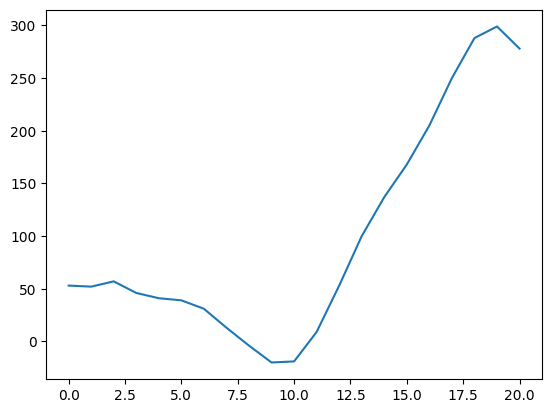

In [16]:
print(info_V1)

y = signals_V1['ECG_Raw'].iloc[638:659].values
x = range(len(y))
print(y)

print(np.diff(((y > 0).astype(int))))
plt.plot(x,y)

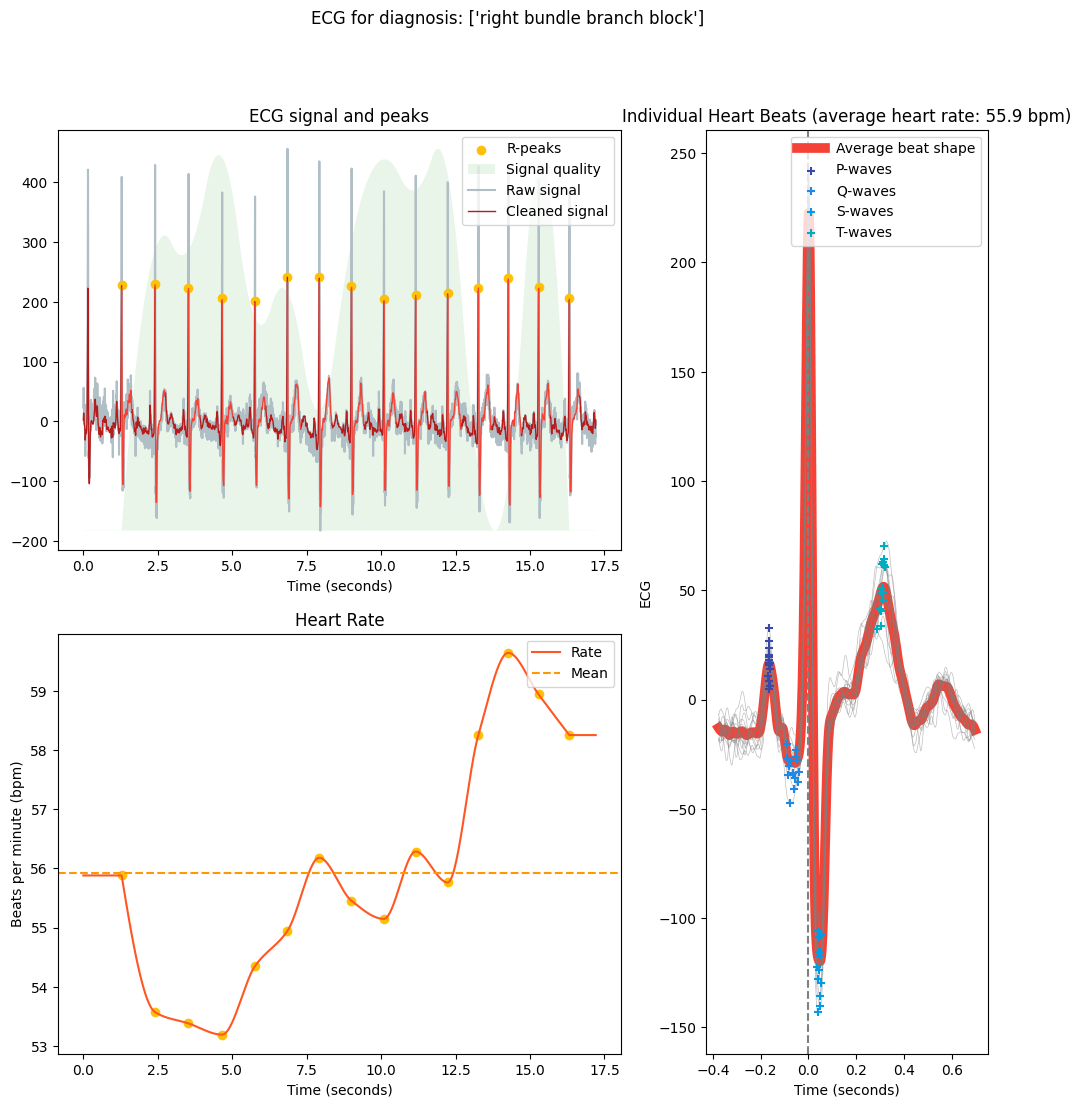

False
False
[0.13, 0.136, 0.102, 0.112, 0.1, 0.138, 0.118, 0.09, 0.1, 0.116, 0.108, 0.088, 0.09, 0.124]
[0.04, 0.046, 0.048, 0.052, 0.052, 0.05, 0.038, 0.034, 0.048, 0.042, 0.044, 0.042, 0.048, 0.04]


In [17]:
signals_V6, info_V6 = nk.ecg_process(recording[11], sampling_rate=500)

# Visualise the processing
plt.close()
nk.ecg_plot(signals_V6, info_V6)
fig = plt.gcf() 
fig.set_size_inches(12, 12, forward=True)
fig.suptitle(f"ECG for diagnosis: {current_abbreviations}")
plt.show()

bpm=np.mean(nk.ecg_rate(signals_V6, sampling_rate=500))

print(has_missing_qrs(signals_V6, info_V6))
print(has_missing_p(signals_V6, info_V6))
print(get_QRS_duration(signals_V6, info_V6))
print(get_S_duration(signals_V6, info_V6))


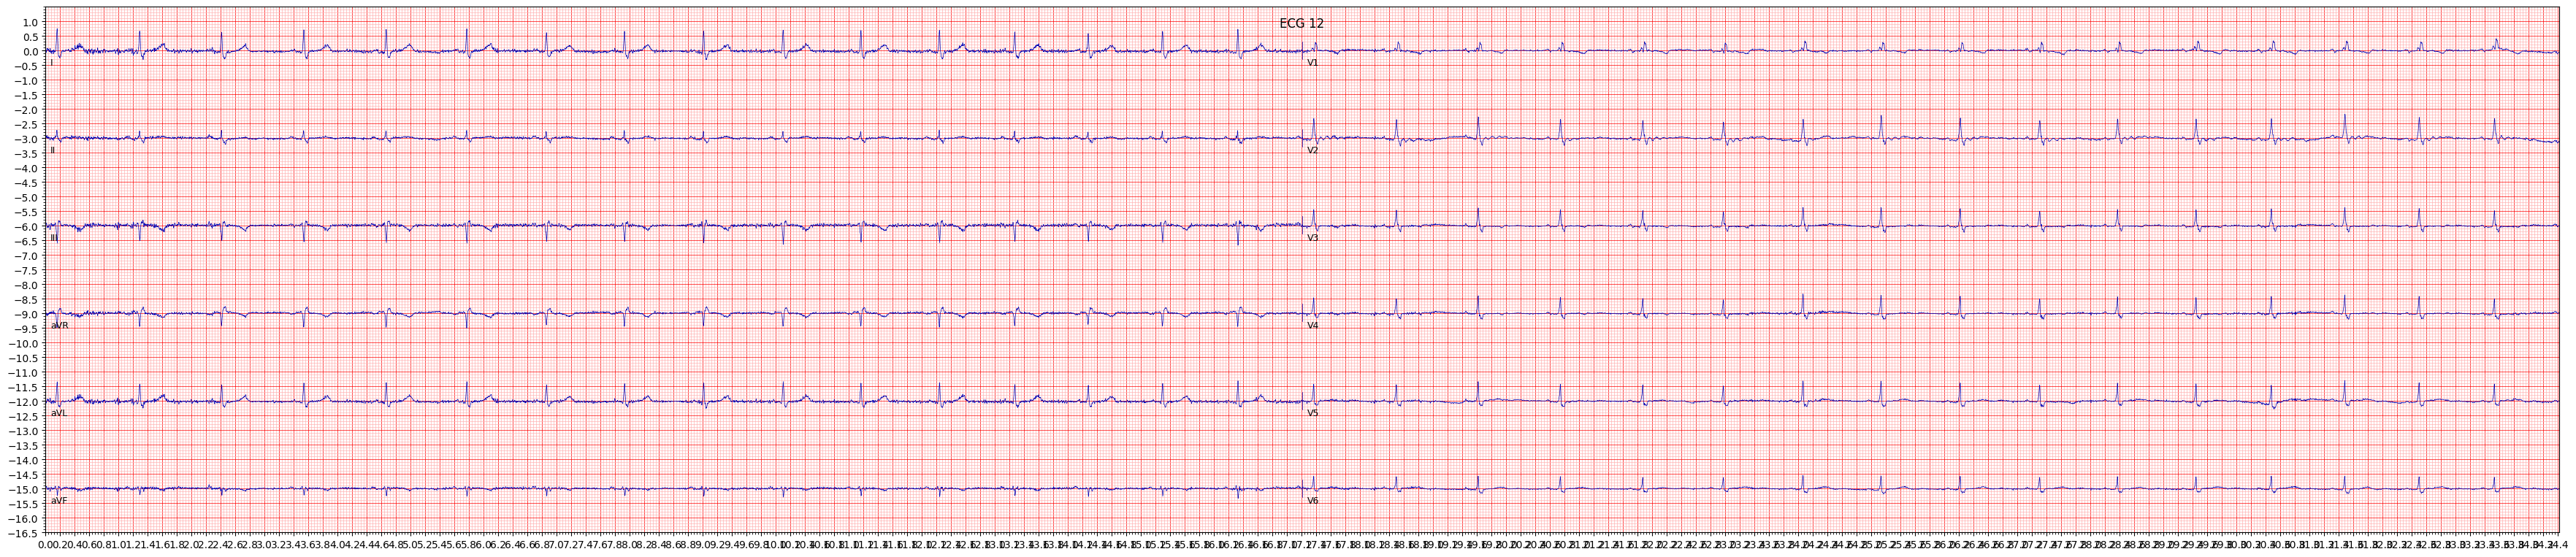

In [18]:
ecg_plot.plot(recording / 1000, sample_rate = 500, title = 'ECG 12')
ecg_plot.show()

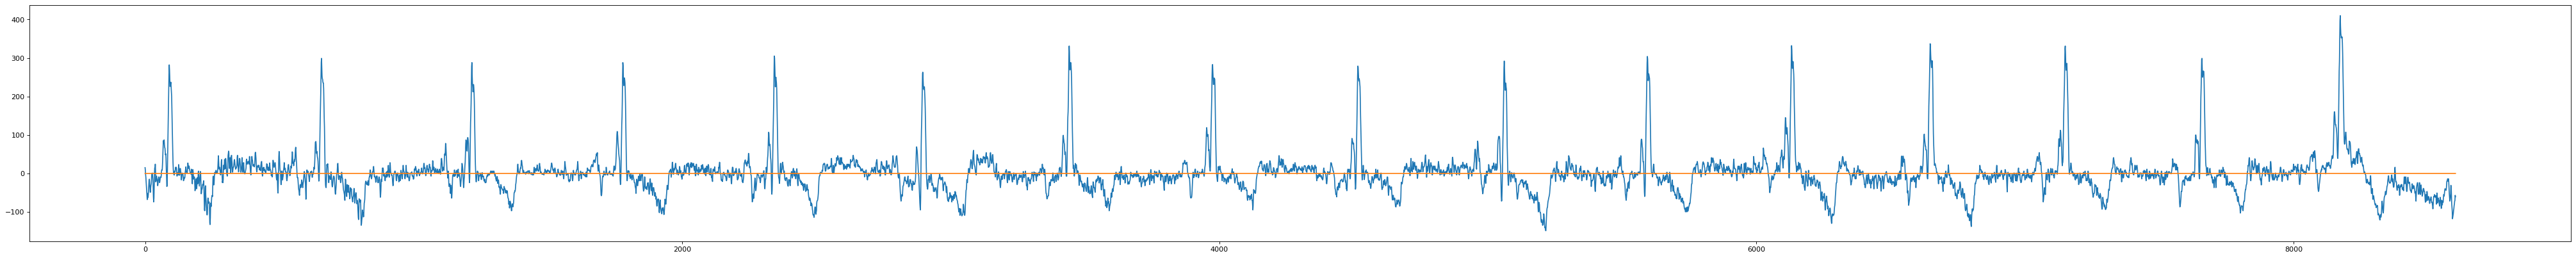

In [19]:
x = range(len(recording[6]))
plt.figure(figsize=(64, 6), dpi=80)
plt.plot(x, recording[6])
plt.plot(x, np.zeros(len(x)))



In [132]:
def has_rsR_complex(recording, threshold=20):
    ecg, inverted = nk.ecg_invert(recording, sampling_rate=500)
    coeff_bigger_20 = []
    #For V1 with rSR there should be no inversion. If V1 is healthy inversion would occurr
    if not inverted:
        signals, info = nk.ecg_process(ecg, sampling_rate=500)
        num_peaks = len(info['ECG_R_Peaks'])
        result = []
        for i in range(num_peaks):
            r = info['ECG_R_Peaks'][i]
            r_on = info['ECG_R_Onsets'][i]
            r_off = info['ECG_R_Offsets'][i]
            p_on = info['ECG_P_Onsets'][i]
            t_off = info['ECG_T_Offsets'][i]
  
            if np.isnan([r, r_on, r_off, p_on, t_off]).any():
                continue
            else:
                # if signals.iloc[r_on]['ECG_Raw'] > 0:
                #     result.append(any(signals.iloc[r_on-threshold:r]['ECG_Raw'] < 0))
                # else:
                    #TODO? What if R_onset is not positive?
                    # Lets see how many times we crossed from positive to negative again, if > 0 between ron and r then its rsr
                    # pos_to_neg_changes = sum((np.diff(signals.iloc[r_on:r]['ECG_Raw']) > 0).astype(int))<0
                    # print((np.diff(signals.iloc[r_on:r]['ECG_Raw']) > 0).astype(int))
                pos_to_neg_changes = sum(np.diff(np.diff(signals.iloc[r_on-threshold:r]['ECG_Raw']) > 0).astype(int))
                (db_cA, db_cD) = pywt.dwt(signals.iloc[p_on: t_off]['ECG_Clean'], 'db2')
                coeff_bigger_20.append(sum(db_cD > 2.5))

                result.append(pos_to_neg_changes>5)

        return int(any(result))
    else:
        rec_clean = nk.ecg_clean(recording, method='pantompkins1985', sampling_rate=500)
        signals, info = nk.ecg_process(rec_clean, sampling_rate=500)
        num_peaks = len(info['ECG_R_Peaks'])
        result = []
        for i in range(num_peaks):
            r = info['ECG_R_Peaks'][i]
            r_on = info['ECG_R_Onsets'][i]
            r_off = info['ECG_R_Offsets'][i]
            p_on = info['ECG_P_Onsets'][i]
            t_off = info['ECG_T_Offsets'][i]
  
            if np.isnan([r, r_on, r_off, p_on, t_off]).any():
                continue
            else:
                # if signals.iloc[r_on]['ECG_Raw'] > 0:
                #     result.append(any(signals.iloc[r_on-threshold:r]['ECG_Raw'] < 0))
                # else:
                    #TODO? What if R_onset is not positive?
                    # Lets see how many times we crossed from positive to negative again, if > 0 between ron and r then its rsr
                    # pos_to_neg_changes = sum((np.diff(signals.iloc[r_on:r]['ECG_Raw']) > 0).astype(int))<0
                    # print((np.diff(signals.iloc[r_on:r]['ECG_Raw']) > 0).astype(int))
                pos_to_neg_changes = sum(np.diff(np.diff(signals.iloc[r: r_off]['ECG_Raw']) > 0).astype(int)) 
                result.append(pos_to_neg_changes>7)
                (db_cA, db_cD) = pywt.dwt(signals.iloc[p_on: t_off]['ECG_Clean'], 'db2')
                coeff_bigger_20.append(sum(db_cD > 5) )
              
        return int(any(result))
        # return -1
        

print(has_rsR_complex(recording[6]))
print(has_rsR_complex(recording_good[6]))
    

1
0


In [21]:
class_files={}
for i in range(len(header_files)):
    header = load_header(header_files[i])
    labels = clean_labels(header)
    #tylko główna diagnoza
    l = labels[0]
    if l in class_files:
        class_files[l].append((header_files[i], recording_files[i]))
        
    else:
        class_files[l]=[(header_files[i], recording_files[i])]

for k, v in class_files.items():
    print(k, len(v))


426783006 135
164884008 98
164889003 173
429622005 111
59118001 250
164931005 30
270492004 103
284470004 74
164909002 26


In [22]:
has_rsr = []
coeffs = []
for header_file, recording_file in class_files['59118001']:
    header = load_header(header_file)
    rec = np.array(load_recording(recording_file), dtype=np.float32)
    has_rsr.append(has_rsR_complex(rec[6]))
    coeffs.append( pywt.dwt(rec[6], 'coif2'))

    

    

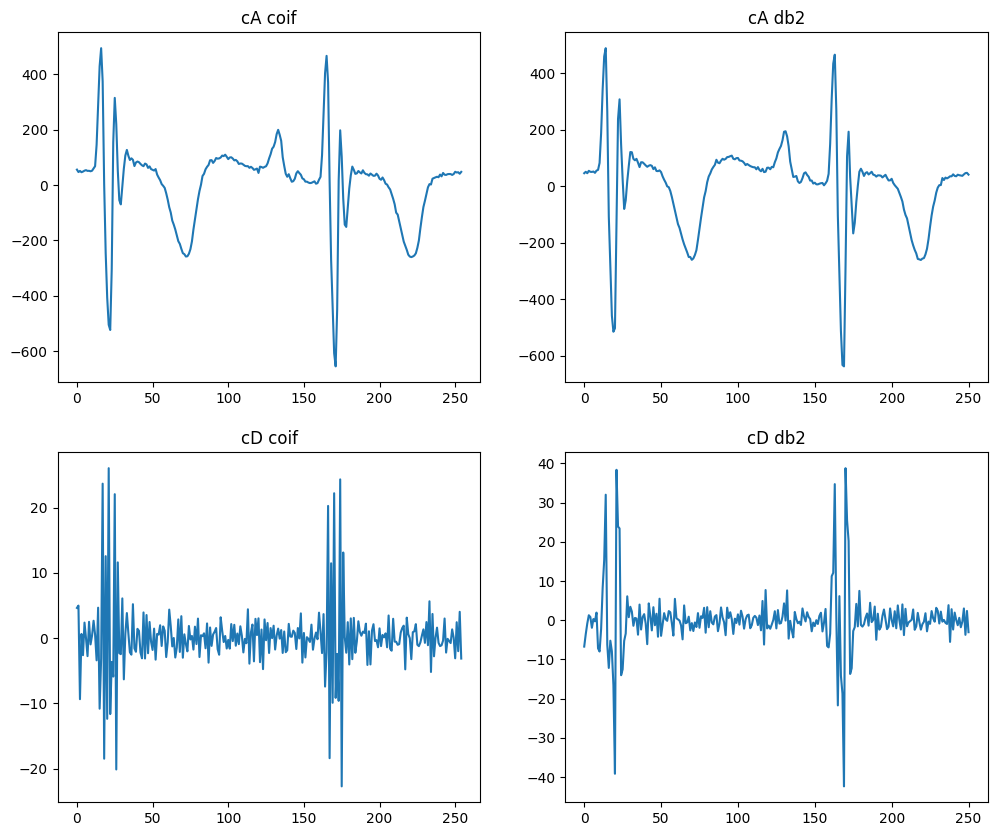

8


In [71]:
header_file, recording_file = class_files['59118001'][-4]
header = load_header(header_file)
rec = np.array(load_recording(recording_file), dtype=np.float32)
(cA, cD) = pywt.dwt(rec[6][:500], 'coif2')
(db_cA, db_cD) = pywt.dwt(rec[6][:500], 'db2')

x = range(len(cA))

figure, axis = plt.subplots(2, 2)
figure.set_size_inches(12,10)
axis[0, 0].plot(x, cA)
axis[0, 0].set_title("cA coif")

axis[1, 0].plot(x, cD)
axis[1, 0].set_title("cD coif")

x = range(len(db_cA))
axis[0, 1].plot(x, db_cA)
axis[0, 1].set_title("cA db2")

axis[1, 1].plot(x, db_cD)
axis[1, 1].set_title("cD db2")

plt.show()

print(sum(db_cD > 20))

[13 15 13 10 11 10 13 14 11 14 10 15 13 16 21 19 11 10]


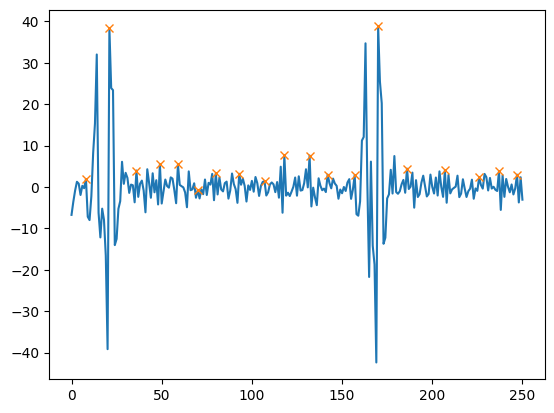

In [24]:
peaks, _ = find_peaks(db_cD, distance=10)
print(np.diff(peaks))
plt.plot(db_cD)
plt.plot(peaks, db_cD[peaks], "x")
plt.show()

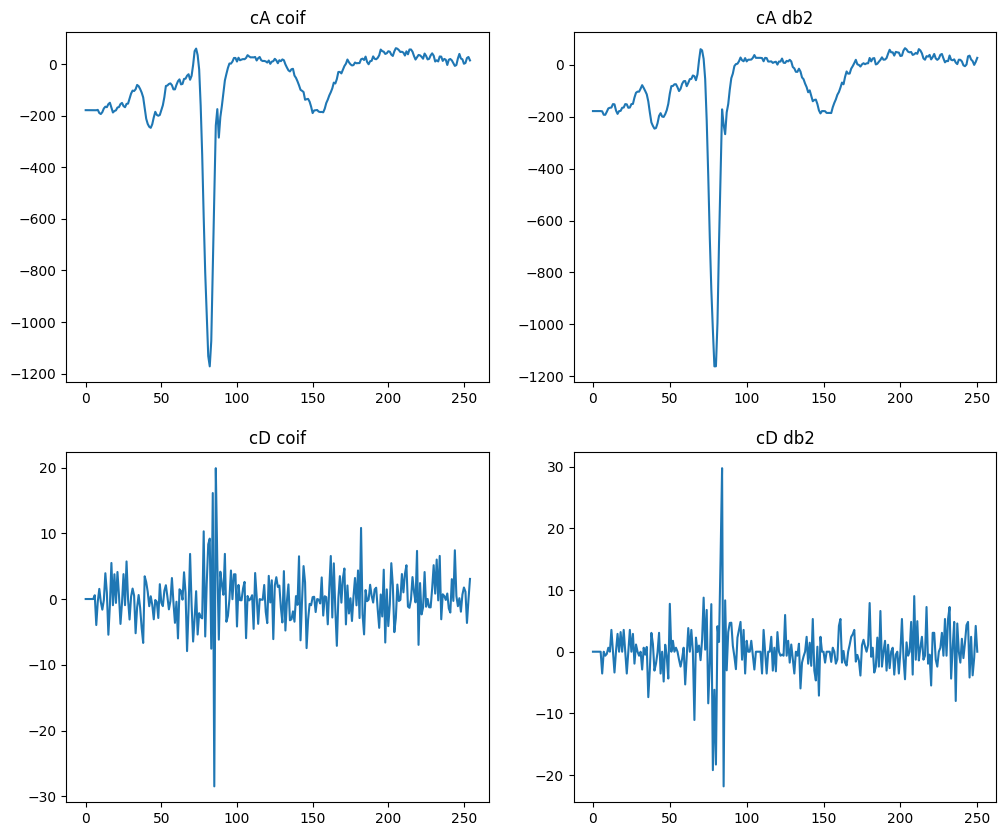

In [25]:
(cA, cD) = pywt.dwt(recording_good[6][:500], 'coif2')
(db_cA, db_cD) = pywt.dwt(recording_good[6][:500], 'db2')
# (cA, cD) = pywt.dwt(recording_good[6][500:1500], 'coif2')
# (db_cA, db_cD) = pywt.dwt(recording_good[6][500:1500], 'db2')


x = range(len(cA))

figure, axis = plt.subplots(2, 2)
figure.set_size_inches(12,10)
axis[0, 0].plot(x, cA)
axis[0, 0].set_title("cA coif")

axis[1, 0].plot(x, cD)
axis[1, 0].set_title("cD coif")

x = range(len(db_cA))
axis[0, 1].plot(x, db_cA)
axis[0, 1].set_title("cA db2")

axis[1, 1].plot(x, db_cD)
axis[1, 1].set_title("cD db2")

plt.show()

[12 14 12 12 10 12 12 15 14 18 18 19 10 19 12 11 12]


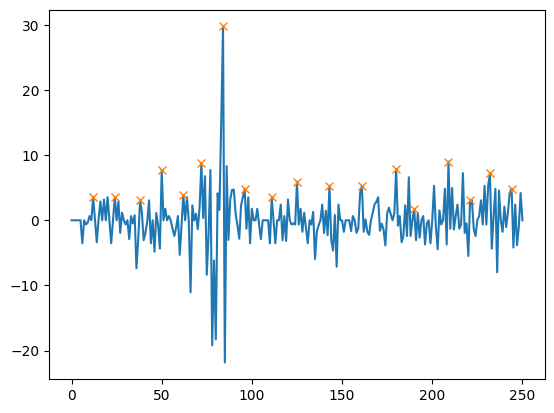

In [26]:
peaks, _ = find_peaks(db_cD, distance=10)
print(np.diff(peaks))
plt.plot(db_cD)
plt.plot(peaks, db_cD[peaks], "x")
plt.show()

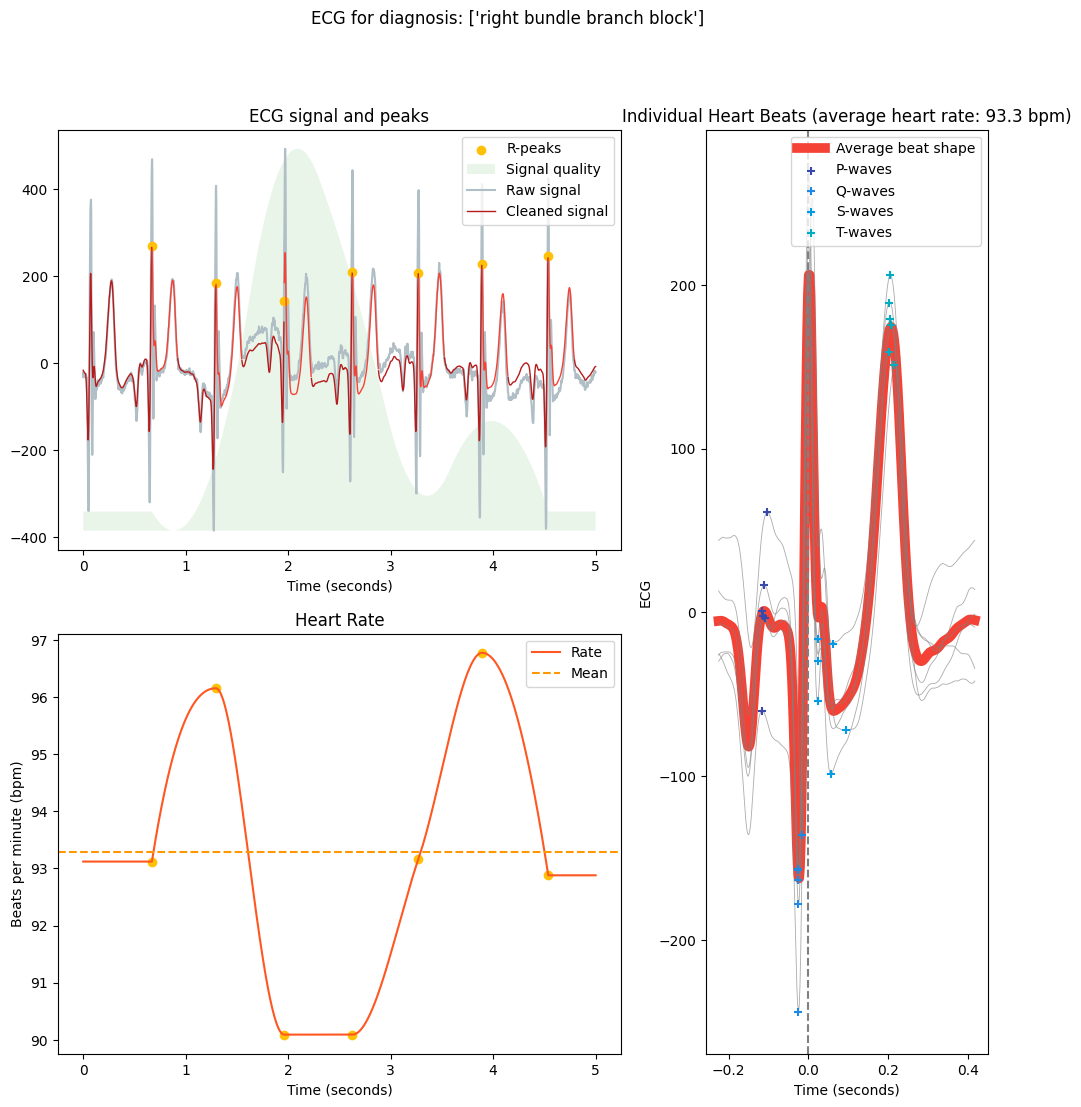

[0.086, 0.082, 0.11, 0.048, 0.048, 0.048]


In [27]:
header_file, recording_file = class_files['59118001'][-4]
header = load_header(header_file)
rec = np.array(load_recording(recording_file), dtype=np.float32)
ecg, inverted = nk.ecg_invert(rec[6][:2500], sampling_rate=500)
signals, info = nk.ecg_process(ecg, sampling_rate=500)
nk.ecg_plot(signals, info)
fig = plt.gcf() 
fig.set_size_inches(12, 12, forward=True)
fig.suptitle(f"ECG for diagnosis: {current_abbreviations}")
plt.show()
print(get_QRS_duration(signals, info))


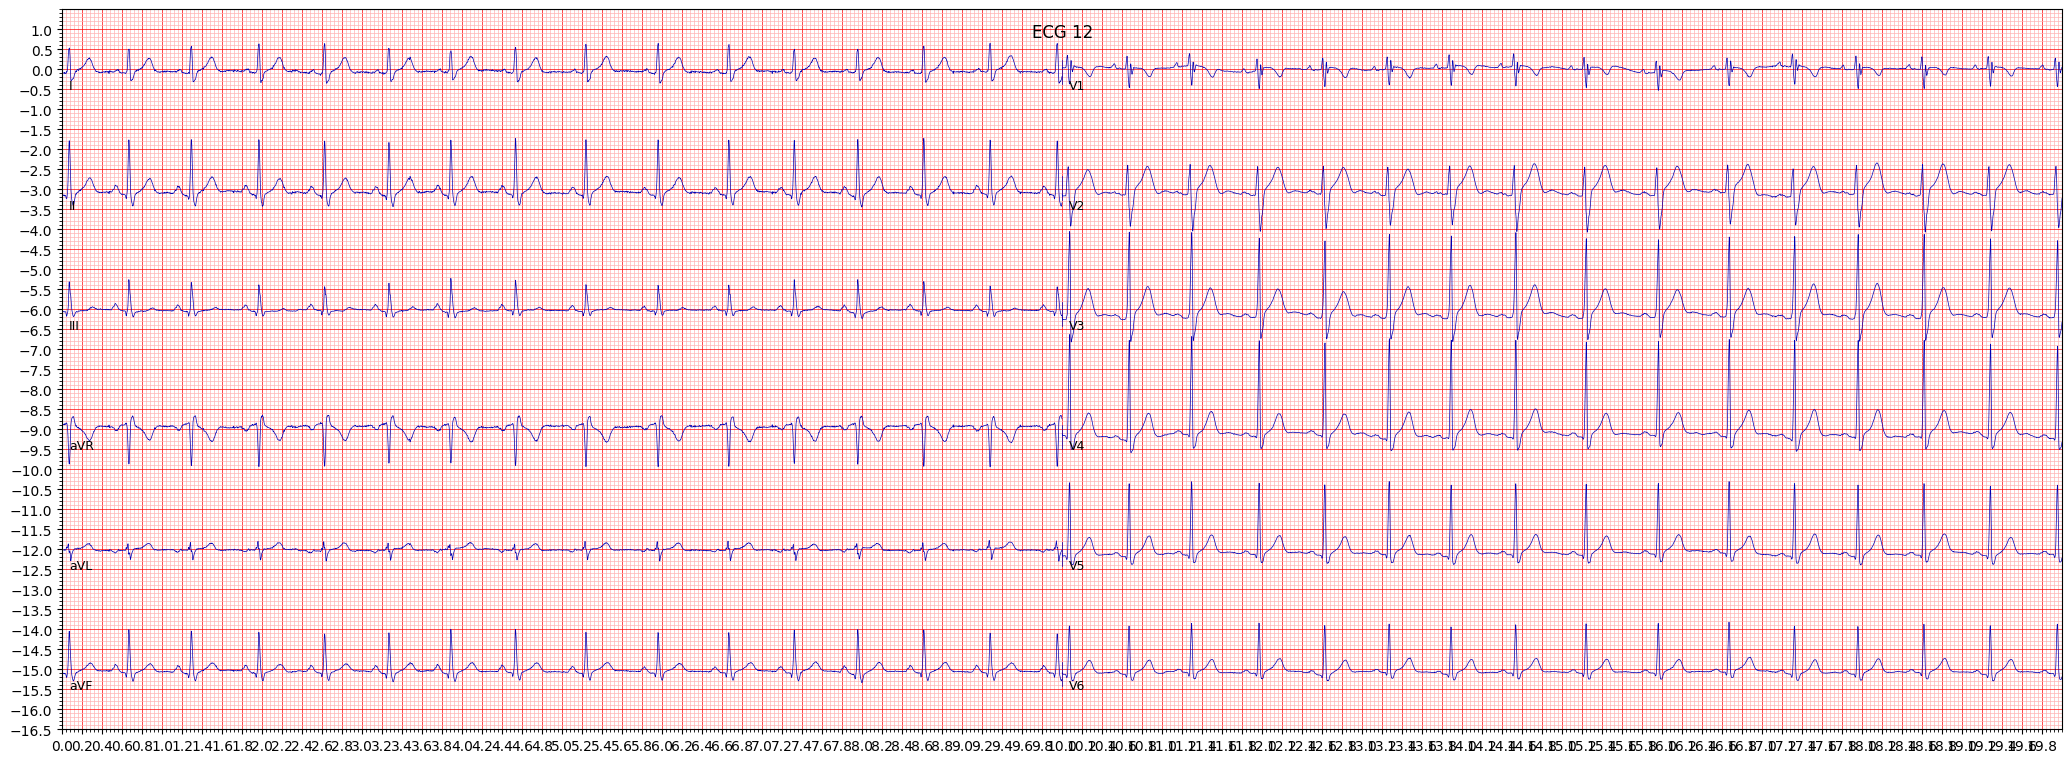

In [28]:
ecg_plot.plot(rec / 1000, sample_rate = 500, title = 'ECG 12')
ecg_plot.show()

# Analysis of LBBB
- Wide Iterlocked R in V5, V6 and aVL
- no Q in I, V5 and V6
- QRS > 120ms
- widened S of more than 60ms in V5 and V6 (eventualy I or aVL)
- ST-T leaning oposite to QRS in V5 V6

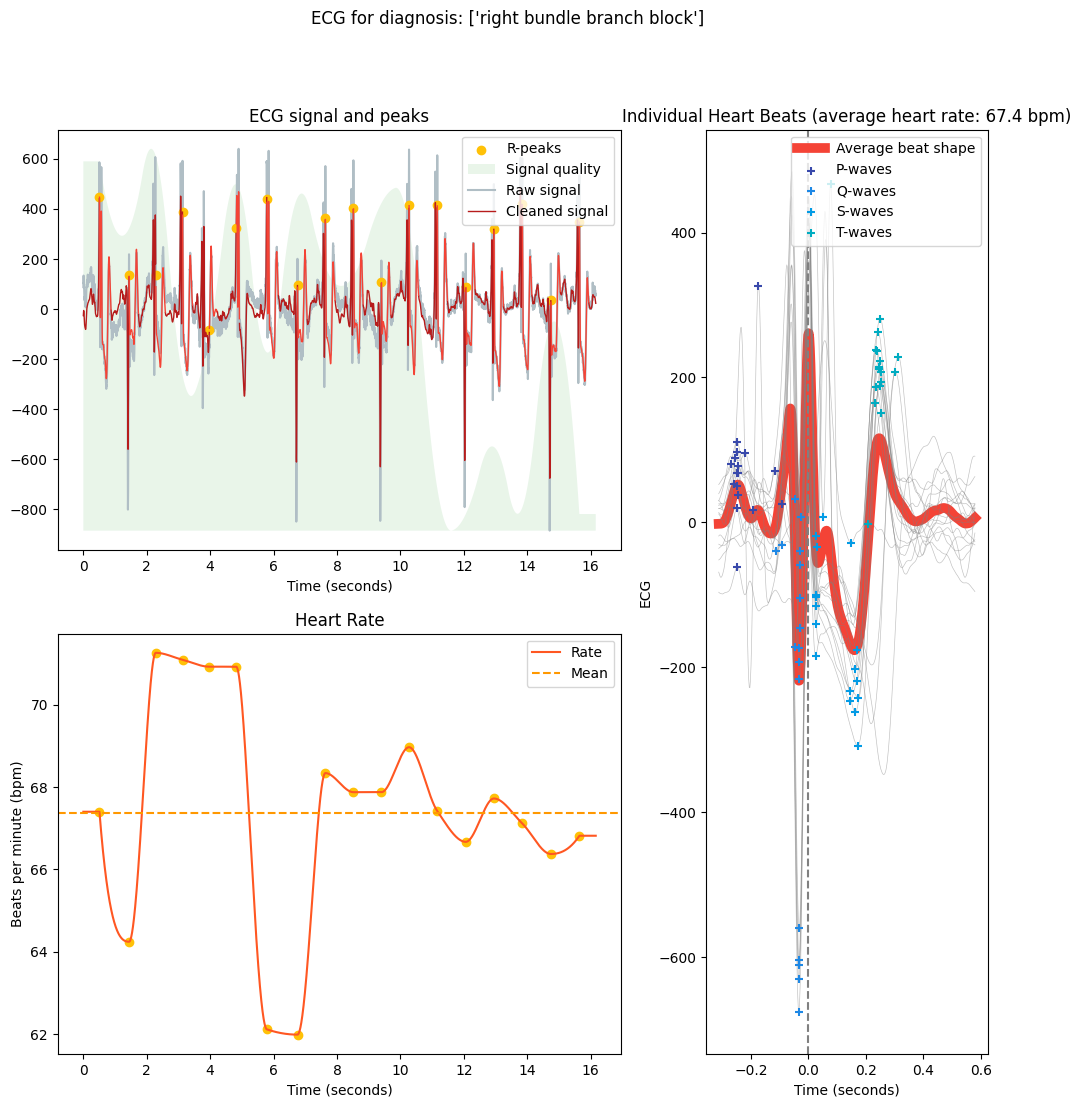

[0.124, 0.06, 0.19, 0.172, 0.178, 0.098, 0.14, 0.06, 0.198, 0.198, 0.06, 0.192, 0.19, 0.06, 0.202, 0.2, 0.058]


In [76]:
coeffs = []
header_file, recording_file = class_files['164909002'][0]
header = load_header(header_file)
rec = np.array(load_recording(recording_file), dtype=np.float32)
signals, info = nk.ecg_process(rec[10], sampling_rate=500)
pywt.dwt(rec[10], 'coif2')
nk.ecg_plot(signals, info)
fig = plt.gcf() 
fig.set_size_inches(12, 12, forward=True)
fig.suptitle(f"ECG for diagnosis: {current_abbreviations}")
plt.show()
print(get_QRS_duration(signals, info))


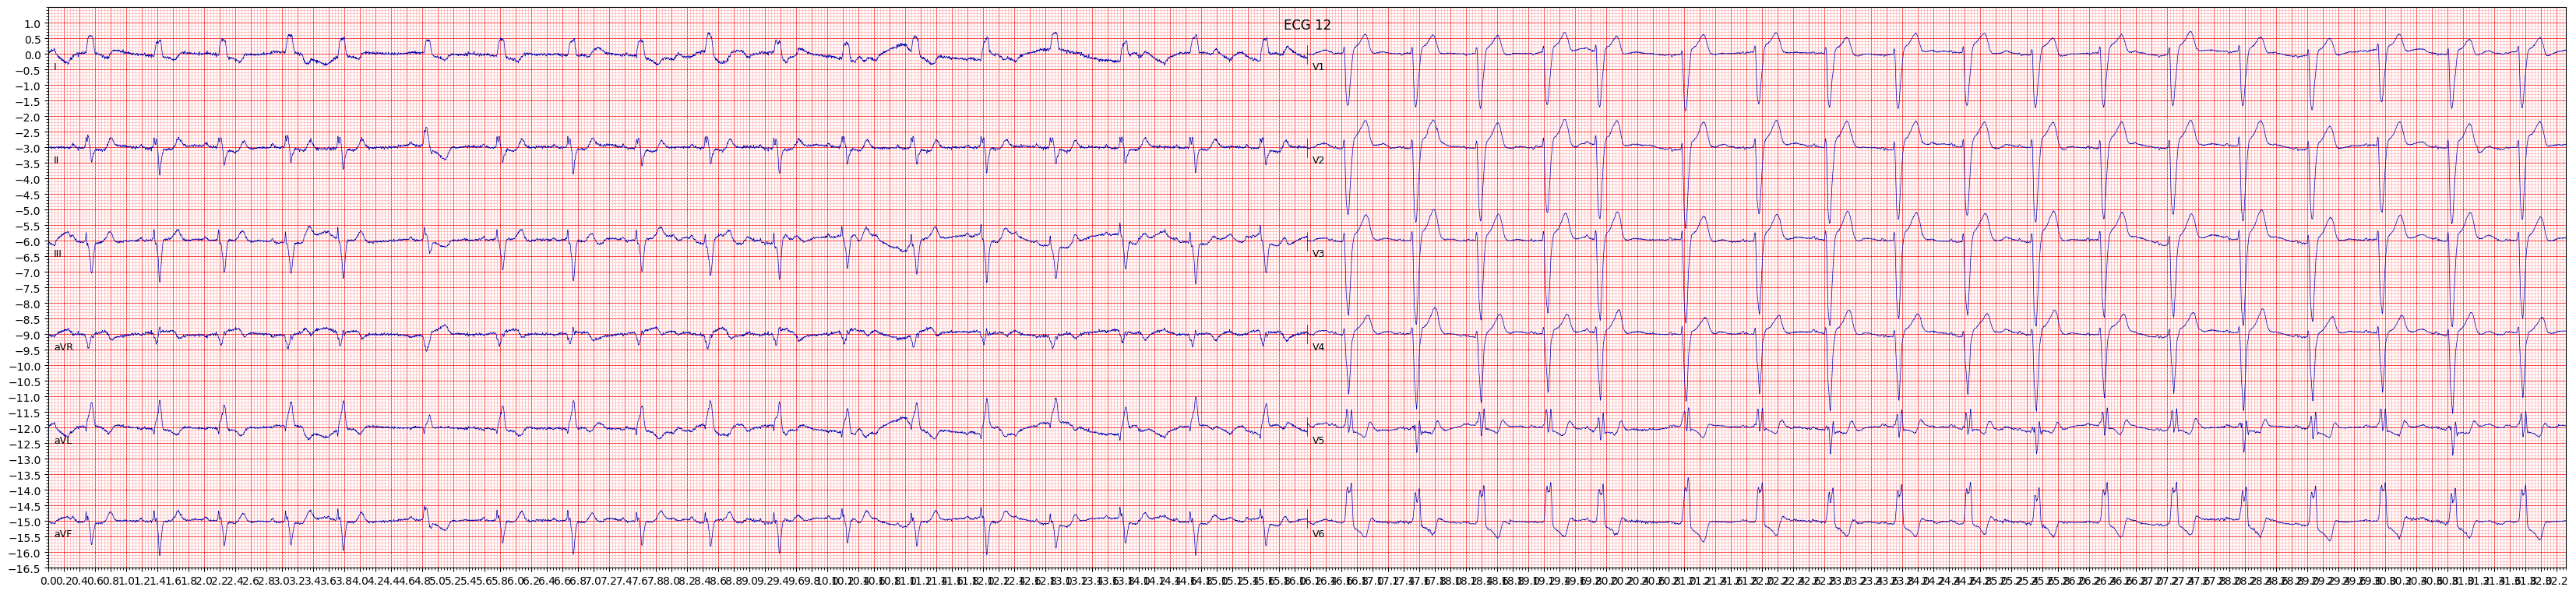

In [77]:
ecg_plot.plot(rec / 1000, sample_rate = 500, title = 'ECG 12')
ecg_plot.show()

[0.202, 0.196, 0.204, 0.198, 0.176]
[0.108, 0.126, 0.116, 0.114, 0.1]


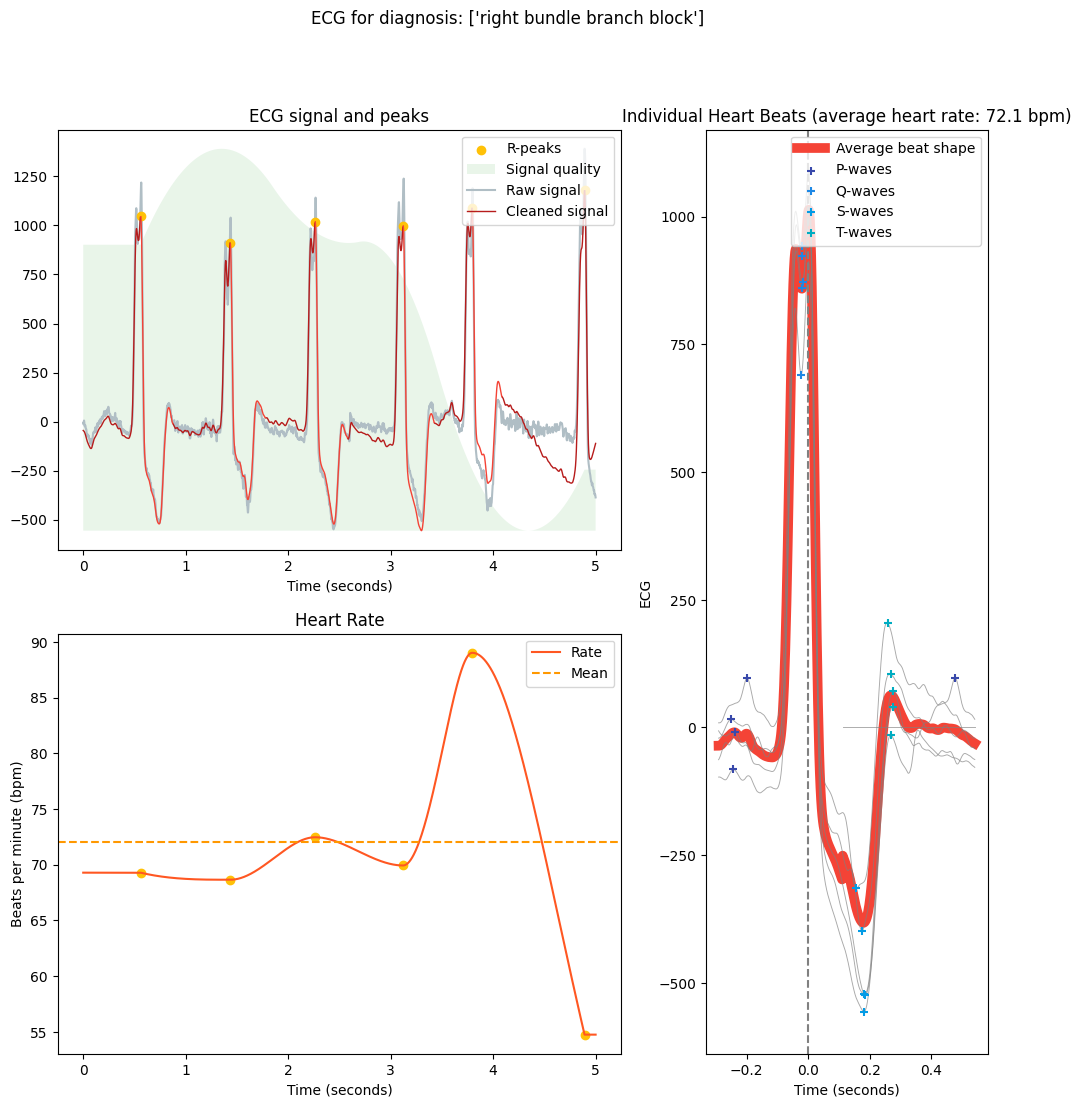

In [78]:
signals, info= nk.ecg_process(rec[11][:2500], sampling_rate=500)

# Visualise the processing
nk.ecg_plot(signals, info)
fig = plt.gcf() 
fig.set_size_inches(12, 12, forward=True)
fig.suptitle(f"ECG for diagnosis: {current_abbreviations}")

print(get_QRS_duration(signals, info))
print(get_R_duration(signals, info))

['bior1.1', 'bior1.3', 'bior1.5', 'bior2.2', 'bior2.4', 'bior2.6', 'bior2.8', 'bior3.1', 'bior3.3', 'bior3.5', 'bior3.7', 'bior3.9', 'bior4.4', 'bior5.5', 'bior6.8']


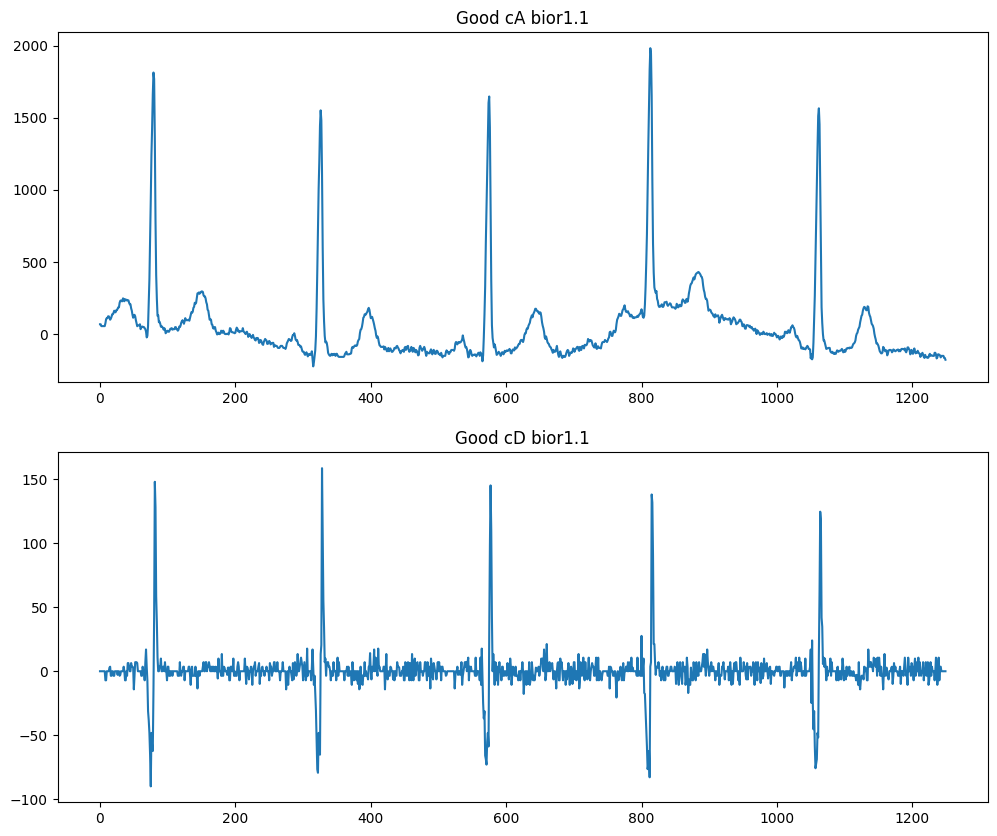

In [81]:
print(pywt.wavelist("bior"))
(cA, cD) = pywt.dwt(rec[11][:2500], 'bior1.1')
(good_cA, good_cD) = pywt.dwt(recording_good[11][:2500], 'bior1.1')


x = range(len(cA))

figure, axis = plt.subplots(2, 1)
figure.set_size_inches(12,10)
axis[0].plot(x, good_cA)
axis[0].set_title("Good cA bior1.1")

axis[1].plot(x, good_cD)
axis[1].set_title("Good cD bior1.1")


plt.show()

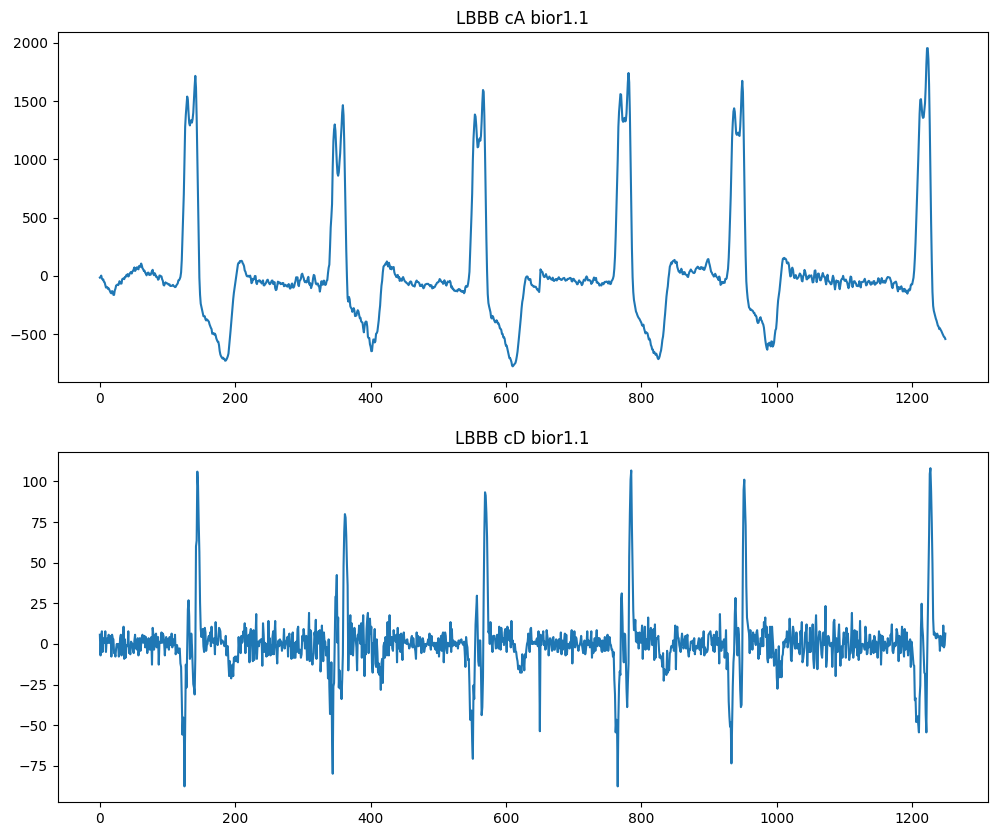

In [82]:
x = range(len(cA))

figure, axis = plt.subplots(2, 1)
figure.set_size_inches(12,10)
axis[0].plot(x, cA)
axis[0].set_title("LBBB cA bior1.1")

axis[1].plot(x, cD)
axis[1].set_title("LBBB cD bior1.1")
plt.show()


# Building features vector

In [158]:
def analyse_recording(rec, leads_idxs, label, sampling_rate=500):
    analysed_results = {}
    for lead_name, idx in leads_idxs.items():
        rec_clean = nk.ecg_clean(rec[idx], method="pantompkins1985", sampling_rate=sampling_rate)
        signal, info =nk.ecg_process(rec_clean, sampling_rate=sampling_rate)
        bpm = np.mean(nk.ecg_rate(signal, sampling_rate))
        missing_qrs = has_missing_qrs(signals, info)
        missing_p = has_missing_p(signals, info)
        qrs_duration = np.mean(get_QRS_duration(signals, info))
        s_duration = np.mean(get_S_duration(signals, info))
        rhythm = leading_rythm(bpm)
        rsr = has_rsR_complex(rec[idx], sampling_rate)

        analysed_results[lead_name]={
            'signal': signal,
            'info': info,
            'bpm': bpm, 
            'missing_qrs':missing_qrs, 
            'missing_p': missing_p, 
            'qrs_duration':qrs_duration, 
            's_duration':s_duration,
            'rhythm': rhythm,
            'has_rsr': rsr,
        }
        
    heart_axis = None
    rhythm_origin = None
    if 'I' in leads_idx:
        if 'II' in leads_idx:
            rhythm_origin = get_rhythm_origin(analysed_results['I']['signal'], analysed_results['I']['info'], analysed_results['II']['signal'], analysed_results['II']['info'])
        if 'aVF' in leads_idx:
            if 'II' not in leads_idx:
                rhythm_origin = get_rhythm_origin(analysed_results['I']['signal'], analysed_results['I']['info'], analysed_results['aVF']['signal'], analysed_results['aVF']['info'])
            heart_axis = get_heart_axis(get_QRS_from_lead(analysed_results['I']['signal'], analysed_results['I']['info']), get_QRS_from_lead(analysed_results['aVF']['signal'], analysed_results['aVF']['info']))
    
    
    if heart_axis:
        analysed_results['heart_axis']=heart_axis

    if rhythm_origin:
        analysed_results['rhythm_origin']=rhythm_origin


    analysed_results['label'] = label
    
    for lead_name, idx in leads_idxs.items():
        analysed_results[lead_name].pop('signal', None)
        analysed_results[lead_name].pop('info', None)

    
    return analysed_results

        

    
    

In [159]:
data_analysis = []
broken_records= []
leads_idx = {'I': 0, 'II': 1, 'III':2, 'aVR': 3, 'aVL':4, 'aVF':5, 'V1':6, 'V2':7, 'V3':8, 'V4':9, 'V5':10, 'V6':11}
data = [class_files[key] for key in ['59118001', '164909002', '426783006']]
data_flattened = []
functools.reduce(operator.iconcat, data, data_flattened)
total = len(data_flattened)
counter = 0
for header_file, recording_file in data_flattened:
    print(f"{counter}/{total}")
    header = load_header(header_file)
    current_label= clean_labels(header)[0]
    rec = np.array(load_recording(recording_file), dtype=np.float32)
    if rec.shape[1] < 2500:
        continue

    try:
        result = analyse_recording(rec, leads_idx, current_label)
        data_analysis.append(result)
    except:
        broken_records.append((header_file, recording_file))
        
    counter +=1
    
df = pd.DataFrame.from_records(data_analysis)
df.to_json("/Users/puszkarb/phd/phd_nbeats_with_feature_vector/notebooks/trainig_data.json")


0/411
1/411
2/411
3/411
4/411
5/411
6/411
7/411
8/411
9/411
10/411
11/411
12/411
13/411
14/411
15/411
16/411
17/411
18/411
19/411
20/411
21/411
22/411
23/411
24/411
25/411
26/411
27/411
28/411
29/411
30/411
31/411
32/411
33/411
34/411
35/411
36/411
37/411
38/411
39/411
40/411
41/411
42/411
43/411
44/411
45/411
46/411
47/411
48/411


/Users/puszkarb/phd/phd_nbeats/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/puszkarb/phd/phd_nbeats/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


49/411
50/411
51/411
52/411
53/411
54/411
55/411
56/411
57/411
58/411
59/411
60/411
61/411
62/411
63/411
64/411
65/411
66/411
67/411
68/411
69/411
70/411
71/411
72/411
73/411
74/411
75/411
76/411
77/411
78/411
79/411
80/411
81/411
82/411
83/411
84/411
85/411
86/411


/Users/puszkarb/phd/phd_nbeats/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/puszkarb/phd/phd_nbeats/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/puszkarb/phd/phd_nbeats/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/puszkarb/phd/phd_nbeats/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/puszkarb/phd/phd_nbeats/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/puszkarb/phd/phd_nbeats/lib/python3.12/site-packages/numpy/core/_methods.py:129: Runt

87/411
88/411
89/411
90/411
91/411
92/411
93/411
94/411
95/411
96/411
97/411
98/411
99/411


/Users/puszkarb/phd/phd_nbeats/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/puszkarb/phd/phd_nbeats/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/puszkarb/phd/phd_nbeats/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/puszkarb/phd/phd_nbeats/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


100/411
101/411
102/411
103/411
104/411
105/411
106/411
107/411
108/411
109/411
110/411
111/411
112/411
113/411
114/411
115/411
116/411
117/411
118/411
119/411
120/411
121/411
122/411
123/411
124/411
125/411
126/411
127/411
128/411
129/411
130/411
131/411
132/411
133/411
134/411
135/411
136/411
137/411
138/411
139/411
140/411
141/411
142/411
143/411
144/411
145/411
146/411
147/411
148/411
149/411
150/411
151/411
152/411
153/411
154/411
155/411
156/411
157/411
158/411
159/411
160/411
161/411
162/411
163/411


/Users/puszkarb/phd/phd_nbeats/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/puszkarb/phd/phd_nbeats/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


164/411
165/411
166/411
167/411
168/411
169/411
170/411
171/411
172/411
173/411
174/411
175/411
176/411
177/411
178/411
179/411
180/411
181/411
182/411
183/411
184/411
185/411
186/411
187/411
188/411
189/411
190/411
191/411
192/411
193/411
194/411
195/411
196/411
197/411
198/411
199/411
200/411
201/411
202/411
203/411
204/411
205/411
206/411
207/411
208/411
209/411
210/411
211/411
212/411
213/411
214/411
215/411
216/411
217/411
218/411
219/411
220/411
221/411
222/411
223/411
224/411
225/411
226/411


/Users/puszkarb/phd/phd_nbeats/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/puszkarb/phd/phd_nbeats/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/puszkarb/phd/phd_nbeats/lib/python3.12/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(


227/411
228/411
229/411
230/411
231/411


/Users/puszkarb/phd/phd_nbeats/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/puszkarb/phd/phd_nbeats/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


232/411
233/411
234/411
235/411
236/411
237/411
238/411
239/411
240/411
241/411
242/411
243/411


/Users/puszkarb/phd/phd_nbeats/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/puszkarb/phd/phd_nbeats/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


244/411
245/411
246/411
247/411
248/411
249/411
250/411
251/411
252/411
253/411
254/411
255/411
256/411
257/411
258/411
259/411
260/411
261/411
262/411
263/411
264/411
265/411
266/411
267/411
268/411
269/411
270/411
271/411
272/411
273/411
274/411
275/411
276/411


/Users/puszkarb/phd/phd_nbeats/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/puszkarb/phd/phd_nbeats/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


277/411
278/411
279/411
280/411
281/411
282/411
283/411
284/411
285/411
286/411
287/411
288/411
289/411
290/411
291/411
292/411
293/411
294/411
295/411
296/411
297/411


/Users/puszkarb/phd/phd_nbeats/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/puszkarb/phd/phd_nbeats/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


298/411
299/411
300/411
301/411
302/411
303/411
304/411
305/411
306/411
307/411
308/411
309/411
310/411
311/411
312/411
313/411
314/411
315/411
316/411
317/411
318/411
319/411
320/411
321/411
322/411
323/411


/Users/puszkarb/phd/phd_nbeats/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/puszkarb/phd/phd_nbeats/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


324/411
325/411
326/411
327/411
328/411
329/411
330/411
331/411
332/411
333/411
334/411
335/411
336/411
337/411


/Users/puszkarb/phd/phd_nbeats/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/puszkarb/phd/phd_nbeats/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


338/411
339/411
340/411
341/411
342/411
343/411
344/411
345/411
346/411
347/411
348/411
349/411
350/411
351/411
352/411
353/411
354/411
355/411
356/411
357/411
358/411
359/411
360/411
361/411
362/411
363/411
364/411
365/411
366/411
367/411
368/411
369/411
370/411
371/411
372/411
373/411
374/411
375/411
376/411
377/411
378/411
379/411
380/411
381/411
382/411
383/411
384/411
385/411
386/411
387/411
388/411
389/411
390/411
391/411
392/411
393/411
394/411
395/411
396/411
397/411
398/411
399/411
400/411
401/411
402/411
403/411


/Users/puszkarb/phd/phd_nbeats/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/puszkarb/phd/phd_nbeats/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


404/411
405/411
406/411
407/411
408/411
409/411
410/411


In [163]:
y = df['label']
X = df.loc[:, df.columns != 'label']

X_train, X_test, y_train, y_test = sk.model_selection.train_test_split(X, y, test_size=0.33, random_state=42)

In [164]:
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)

TypeError: float() argument must be a string or a real number, not 'dict'